In [1]:
import findspark
import os
import sys
findspark.init("/Users/fannydouchet/Downloads/spark-2.4.0-bin-hadoop2.7")

from pyspark import SparkContext, SparkConf, SQLContext
os.environ['SPARK_LOCAL_HOSTNAME'] = 'localhost'
os.environ['SPARK_LOCAL_IP'] = '127.0.0.1'
sc = SparkContext()
sc

<SparkContext master=local[*] appName=pyspark-shell>

In [3]:
# instruction lecture de fichier SQL pour spark
sqlsc = SQLContext(sc)

# Data collection

## Bonus 1

In [210]:
def import_data(loc,first_year, last_year):
    """ 
        import data from a gas, stations and services file and unzip it
    """
    import zipfile
    import requests
    import urllib.request
 
    # Copy a network object to a local file

    
    table = ["Prix", "Stations", "Services"]
    
    for i in range(first_year, last_year + 1):
        for t in table :
            i = str(i)
            ti = t + i
            tiz = ti+".zip"
            ltiz = loc + tiz
            r = requests.get(ltiz)
            open(tiz, 'wb').write(r.content)
            with zipfile.ZipFile(tiz,"r") as zip_ref:
                zip_ref.extractall("data")

## Bonus 2

In [211]:
import yaml

PARAMETERS_FILE = 'par_mp.yaml'
with open(PARAMETERS_FILE) as yaml_file:
    config = yaml.load(yaml_file)
    loc = config['loc']
    first_year = config['first_year']
    last_year = config['last_year']

In [212]:
# On ne peut pas récupèrer les fichiers pour 2015 car il n'existe pas pour 'Stations' et 'Services'
import_data(loc, first_year, last_year)

/anaconda3/lib/python3.6/site-packages/requests/__init__.py:80: RequestsDependencyWarning: urllib3 (1.22) or chardet (2.3.0) doesn't match a supported version!
  RequestsDependencyWarning)


# Data Preparation
## Step 1 - Merging gas prices files
### Read and merge all gas files
#### Read gas files

In [4]:
prix_2016 = sqlsc.read.option('sep',';').option('header','false').option('inferSchema','true').csv('/Users/fannydouchet/Desktop/Homework_bigdata/Prix2016.csv')
prix_2017 = sqlsc.read.option('sep',';').option('header','false').option('inferSchema','true').csv('/Users/fannydouchet/Desktop/Homework_bigdata/Prix2017.csv')

In [5]:
### On donne des noms aux champs
prix_2016 = prix_2016.selectExpr(
    '_c0 as id_station',
    '_c1 as code_postal',
    '_c2 as type_station',
    '_c3 as latitude',
    '_c4 as longitude',
    '_c5 as date_releve',
    '_c6 as type_carburant',
    '_c7 as libelle_carburant',
    '_c8/1000 as prix'
).dropna(subset=['libelle_carburant']).cache()

prix_2017 = prix_2017.selectExpr(
    '_c0 as id_station',
    '_c1 as code_postal',
    '_c2 as type_station',
    '_c3 as latitude',
    '_c4 as longitude',
    '_c5 as date_releve',
    '_c6 as type_carburant',
    '_c7 as libelle_carburant',
    '_c8/1000 as prix'
).dropna(subset=['libelle_carburant']).cache()

In [6]:
prix_2016.printSchema()

root
 |-- id_station: integer (nullable = true)
 |-- code_postal: integer (nullable = true)
 |-- type_station: string (nullable = true)
 |-- latitude: double (nullable = true)
 |-- longitude: double (nullable = true)
 |-- date_releve: timestamp (nullable = true)
 |-- type_carburant: integer (nullable = true)
 |-- libelle_carburant: string (nullable = true)
 |-- prix: double (nullable = true)



In [7]:
## Avec cette commande on créer un df comme une table pour l'exploiter en SQL
sqlsc.registerDataFrameAsTable(prix_2016, 'prix2016')
sqlsc.registerDataFrameAsTable(prix_2017, 'prix2017')

In [8]:
# Même stx mais plus légère
spark = sqlsc.sparkSession

#### Merge gas files

In [9]:
data_merge = (spark.sql(
    "SELECT * "
    "FROM prix2016 "
    "union "
    "SELECT * "
    "FROM prix2017 ").cache())

In [10]:
sqlsc.registerDataFrameAsTable(data_merge, 'df_prix')

### Split date in year, month, week of the year

In [11]:
df_prix = spark.sql(
    "SELECT *, date(date_releve) as date, weekofyear(date_releve) as week, month(date_releve) as month, year(date_releve) as year " 
    "FROM df_prix ")

In [12]:
sqlsc.registerDataFrameAsTable(df_prix, 'df_prix')

In [13]:
spark.sql('SELECT * '
          'FROM df_prix')

DataFrame[id_station: int, code_postal: int, type_station: string, latitude: double, longitude: double, date_releve: timestamp, type_carburant: int, libelle_carburant: string, prix: double, date: date, week: int, month: int, year: int]

### Prepare latitude & longitude for mapping

In [14]:
df_prix=spark.sql("SELECT *, latitude/100000 as lat, longitude/100000 as long " 
                 "FROM df_prix ").cache().createOrReplaceTempView('data_1')

In [15]:
df_prix = spark.sql("SELECT id_station, code_postal, type_station, lat, long, date_releve, date(date_releve) as date, weekofyear(date_releve) as week, month(date_releve) as month, year(date_releve) as year, libelle_carburant, prix "
                   "FROM data_1 ")

In [16]:
sqlsc.registerDataFrameAsTable(df_prix, 'data_prix')

In [16]:
spark.sql('SELECT * '
          'FROM data_prix').show(5)

+----------+-----------+------------+--------+-------+-------------------+----------+----+-----+----+-----------------+-----+
|id_station|code_postal|type_station|     lat|   long|        date_releve|      date|week|month|year|libelle_carburant| prix|
+----------+-----------+------------+--------+-------+-------------------+----------+----+-----+----+-----------------+-----+
|   1000001|       1000|           R|46.20114|5.19791|2016-10-18 09:10:04|2016-10-18|  42|   10|2016|           Gazole|1.149|
|   1000002|       1000|           R|46.21842|5.22767|2016-03-10 09:03:08|2016-03-10|  10|    3|2016|             SP95|1.236|
|   1000002|       1000|           R|46.21842|5.22767|2016-04-16 10:04:38|2016-04-16|  15|    4|2016|             SP95|1.286|
|   1000002|       1000|           R|46.21842|5.22767|2016-07-15 09:07:14|2016-07-15|  28|    7|2016|             SP98|1.287|
|   1000002|       1000|           R|46.21842|5.22767|2016-12-04 09:12:00|2016-12-04|  48|   12|2016|             SP98

## STEP 2 - Deduplicating station
### Read and merge all stations files
#### Read all stations files

In [17]:
stations_2016 = sqlsc.read.option('sep','|').option('header','false').option('inferSchema','true').csv('/Users/fannydouchet/Desktop/Homework_bigdata/Stations2016.csv')
stations_2017 = sqlsc.read.option('sep','|').option('header','false').option('inferSchema','true').csv('/Users/fannydouchet/Desktop/Homework_bigdata/Stations2017.csv')

In [18]:
stations_2016 = stations_2016.selectExpr(
    '_c0 as id_station_bis',
    '_c1 as code_postal',
    '_c2 as pop_type',
    '_c3 as latitude',
    '_c4 as longitude',
    '_c5 as address',
    '_c6 as city'
)

stations_2017 = stations_2017.selectExpr(
    '_c0 as id_station_bis',
    '_c1 as code_postal',
    '_c2 as pop_type',
    '_c3 as latitude',
    '_c4 as longitude',
    '_c5 as address',
    '_c6 as city'
)

In [19]:
sqlsc.registerDataFrameAsTable(stations_2016, 'station2016')
sqlsc.registerDataFrameAsTable(stations_2017, 'station2017')

### Importation services

In [20]:
services_2017 = (spark.read.load('/Users/fannydouchet/Desktop/Homework_bigdata/Services2017.csv',
                                format='csv', sep='|', header='false', interSchema='true')
                .selectExpr(
                    '_c0 as id_station',
                    '_c1 as code_postal',
                    '_c2 as type_station',
                    '_c3 as latitude',
                    '_c4 as longitude',
                    '_c5 as services'
                )
                .dropna(subset=['services']) #enlève les missing values, seulement sur la colonne services
                .cache()
               )

#### Merge all stations files

In [21]:
station_merge = (spark.sql("SELECT * "
                           "FROM station2016 "
                           "union "
                           "SELECT * "
                           "FROM station2017 ").cache())

In [22]:
sqlsc.registerDataFrameAsTable(station_merge, 'data_station')

In [23]:
station_merge = spark.sql("SELECT *, latitude/100000 as lat_station, longitude/100000 as long_station "
                          "FROM data_station")

In [24]:
station_merge = spark.sql('SELECT id_station_bis, code_postal, pop_type, address, city, latitude/100000 as lat_station, longitude/100000 as long_station '
                          'FROM data_station')

In [25]:
sqlsc.registerDataFrameAsTable(station_merge, 'data_station')

### Deduplicate stations based on location

#### Group by stations by selected deduplication key(s)

In [26]:
spark.sql('SELECT address, max(id_station_bis) as id_station '
          'FROM data_station '
          'GROUP BY address, id_station_bis').cache().createOrReplaceTempView('station_by_addr')

#### Generate a unique 

In [27]:
spark.sql('SELECT station_by_addr.id_station as unique_ID, data_station.id_station_bis as station_id '
          'FROM station_by_addr, data_station '
          'WHERE station_by_addr.address=data_station.address').cache().createOrReplaceTempView('table_mapping')

In [28]:
sqlsc.sql('SELECT * from table_mapping').show(10)

+---------+----------+
|unique_ID|station_id|
+---------+----------+
| 52100015|  51120004|
| 52100015|  51320003|
| 52100015|  52100017|
| 52100015|  52100015|
| 27950001|  76220002|
| 27950001|  27460003|
| 27950001|  27460002|
| 27950001|  27460002|
| 27950001|  76430005|
| 27950001|  76430005|
+---------+----------+
only showing top 10 rows



#### Generate a mapping table associating station id in the file with this unique ID

In [28]:
table_merge = (spark.sql("SELECT * FROM table_mapping, data_prix "
          "WHERE table_mapping.station_id = data_prix.id_station"))

In [29]:
sqlsc.registerDataFrameAsTable(table_merge, 'table_merge')

### Indice price 

In [31]:
sqlsc.sql('SELECT * from table_merge').show(10)

+---------+----------+----------+-----------+------------+--------+-------+-------------------+----------+----+-----+----+-----------------+-----+
|unique_ID|station_id|id_station|code_postal|type_station|     lat|   long|        date_releve|      date|week|month|year|libelle_carburant| prix|
+---------+----------+----------+-----------+------------+--------+-------+-------------------+----------+----+-----+----+-----------------+-----+
|  1000001|   1000001|   1000001|       1000|           R|46.20114|5.19791|2016-10-18 09:10:04|2016-10-18|  42|   10|2016|           Gazole|1.149|
|  1000002|   1000002|   1000002|       1000|           R|46.21842|5.22767|2016-03-10 09:03:08|2016-03-10|  10|    3|2016|             SP95|1.236|
|  1000002|   1000002|   1000002|       1000|           R|46.21842|5.22767|2016-04-16 10:04:38|2016-04-16|  15|    4|2016|             SP95|1.286|
|  1000002|   1000002|   1000002|       1000|           R|46.21842|5.22767|2016-07-15 09:07:14|2016-07-15|  28|    7|2

In [30]:
prix_day_df=spark.sql(
    'SELECT libelle_carburant, day(date) as day, round(avg(prix),3) as prix_day '
    'FROM table_merge '
    'WHERE libelle_carburant is not null '
    'GROUP BY libelle_carburant, day(date) '
).toPandas()

In [31]:
prix_day_df.head()

libelle_carburant  day  prix_day
0               E10   22     1.316
1              GPLc   26     0.720
2            Gazole   20     1.176
3              SP95   19     1.335
4            Gazole   14     1.180

In [32]:
spark.sql(
    'SELECT libelle_carburant, date(date_releve) as date, round(avg(prix),3) as prix_day '
    'FROM table_merge '
    'WHERE libelle_carburant is not null '
    'GROUP BY libelle_carburant, date(date_releve) '
).cache().createOrReplaceTempView('prix_day_df')

In [33]:
sqlsc.sql('SELECT * FROM prix_day_df').show(10)

+-----------------+----------+--------+
|libelle_carburant|      date|prix_day|
+-----------------+----------+--------+
|           Gazole|2016-12-13|   1.204|
|           Gazole|2016-08-02|   1.099|
|              E85|2016-08-23|   0.697|
|             GPLc|2016-06-03|   0.686|
|              E85|2016-05-18|   0.711|
|             SP98|2017-07-31|   1.395|
|             GPLc|2017-09-10|   0.762|
|           Gazole|2017-08-21|   1.199|
|              E10|2017-08-18|   1.325|
|              E85|2017-07-15|   0.668|
+-----------------+----------+--------+
only showing top 10 rows



In [34]:
#Jointure interne, jointure stricte
spark.sql(
    'SELECT unique_ID, id_station, table_merge.libelle_carburant, date(date_releve) as date,100*(1+((prix_day_df.prix_day-avg(prix))/avg(prix))) as indice '
    'FROM table_merge, prix_day_df '
    'WHERE table_merge.libelle_carburant is not null '
        'and table_merge.libelle_carburant = prix_day_df.libelle_carburant and date(date_releve) = prix_day_df.date '
    'GROUP BY unique_ID, id_station, table_merge.libelle_carburant, date(date_releve), prix_day_df.prix_day'
).show()

+---------+----------+-----------------+----------+------------------+
|unique_ID|id_station|libelle_carburant|      date|            indice|
+---------+----------+-----------------+----------+------------------+
| 68250001|   1700003|           Gazole|2016-04-20|101.60832544938508|
| 68250004|   1700003|           Gazole|2016-10-25|102.00174064403828|
|  1800001|   1800001|           Gazole|2016-03-01|104.66058763931103|
|  4103001|   4103001|              E10|2016-02-26|106.86274509803921|
|  5000018|   5000018|             SP98|2016-02-25| 92.84682080924856|
|  9000004|   9000004|             SP95|2016-01-16| 99.60660896931552|
| 10150003|  10150003|           Gazole|2016-02-20| 84.19753086419752|
| 10180001|  10180001|             SP98|2016-04-22|100.29498525073745|
| 11100010|  11100010|              E10|2016-04-18|102.15139442231076|
| 11100013|  11100013|              E85|2016-10-27| 85.85732165206508|
| 13127010|  13127010|             GPLc|2016-11-08| 94.85396383866482|
| 1921

In [35]:
spark.sql(
    'SELECT unique_ID, id_station, code_postal, table_merge.libelle_carburant, date(date_releve) as date, 100*(1 +((prix_day_df.prix_day-avg(prix))/avg(prix))) as indice_base100, avg(prix)/prix_day_df.prix_day as indice  '
    'FROM table_merge, prix_day_df '
    'WHERE table_merge.libelle_carburant is not null '
        'and table_merge.libelle_carburant = prix_day_df.libelle_carburant and date(date_releve) = prix_day_df.date '
    'GROUP BY unique_ID, id_station, table_merge.libelle_carburant, date(date_releve), prix_day_df.prix_day, code_postal'
).cache().createOrReplaceTempView('indice_prix')

#Creation d'une table spark SQL indice_prix

In [36]:
spark.sql(
    'SELECT unique_ID, id_station, code_postal, indice_prix.libelle_carburant, indice_prix.date , prix_day_df.prix_day, indice_prix.indice_base100, indice_prix.indice '
    'FROM indice_prix, prix_day_df '
    'WHERE indice_prix.libelle_carburant = prix_day_df.libelle_carburant and indice_prix.date = prix_day_df.date '
).cache().createOrReplaceTempView('price_index_stations')

In [37]:
# trop gros donc on fait un where pour selectionner les données pour une seule ville
spark.sql(
    'SELECT * '
    'FROM price_index_stations '
    'WHERE code_postal = 1000 '
   # 'GROUP BY libelle_carburant, date_releve '
).cache().createOrReplaceTempView('average_day_price_sample')

In [40]:
sqlsc.sql('SELECT * from average_day_price_sample').show(10)

+---------+----------+-----------+-----------------+----------+--------+------------------+------------------+
|unique_ID|id_station|code_postal|libelle_carburant|      date|prix_day|    indice_base100|            indice|
+---------+----------+-----------+-----------------+----------+--------+------------------+------------------+
|  1000008|   1000008|       1000|             SP95|2017-10-16|   1.369|104.34451219512195|  0.95836376917458|
|  1000013|   1000013|       1000|           Gazole|2017-08-11|   1.204|102.12044105173877|0.9792358803986712|
|  1000009|   1000009|       1000|              E10|2016-03-07|   1.212|102.53807106598984|0.9752475247524752|
|  1000013|   1000013|       1000|              E10|2016-05-20|    1.32|104.34782608695654|0.9583333333333333|
|  1000001|   1000001|       1000|             SP95|2017-07-12|   1.333|101.06141015921153|0.9894973743435859|
|  1000013|   1000013|       1000|           Gazole|2017-03-01|   1.273|102.33118971061093|0.9772191673212883|
|

In [38]:
avg_price = spark.sql(
    'SELECT * '
    'FROM average_day_price_sample '
    'WHERE prix_day > 0.8 AND prix_day < 1.8 '
).toPandas()

In [39]:
avg_price.head()

unique_ID  id_station  code_postal libelle_carburant        date  prix_day  \
0    1000008     1000008         1000              SP95  2017-10-16     1.369   
1    1000013     1000013         1000            Gazole  2017-08-11     1.204   
2    1000009     1000009         1000               E10  2016-03-07     1.212   
3    1000013     1000013         1000               E10  2016-05-20     1.320   
4    1000001     1000001         1000              SP95  2017-07-12     1.333   

   indice_base100    indice  
0      104.344512  0.958364  
1      102.120441  0.979236  
2      102.538071  0.975248  
3      104.347826  0.958333  
4      101.061410  0.989497

## Data Visualization 1

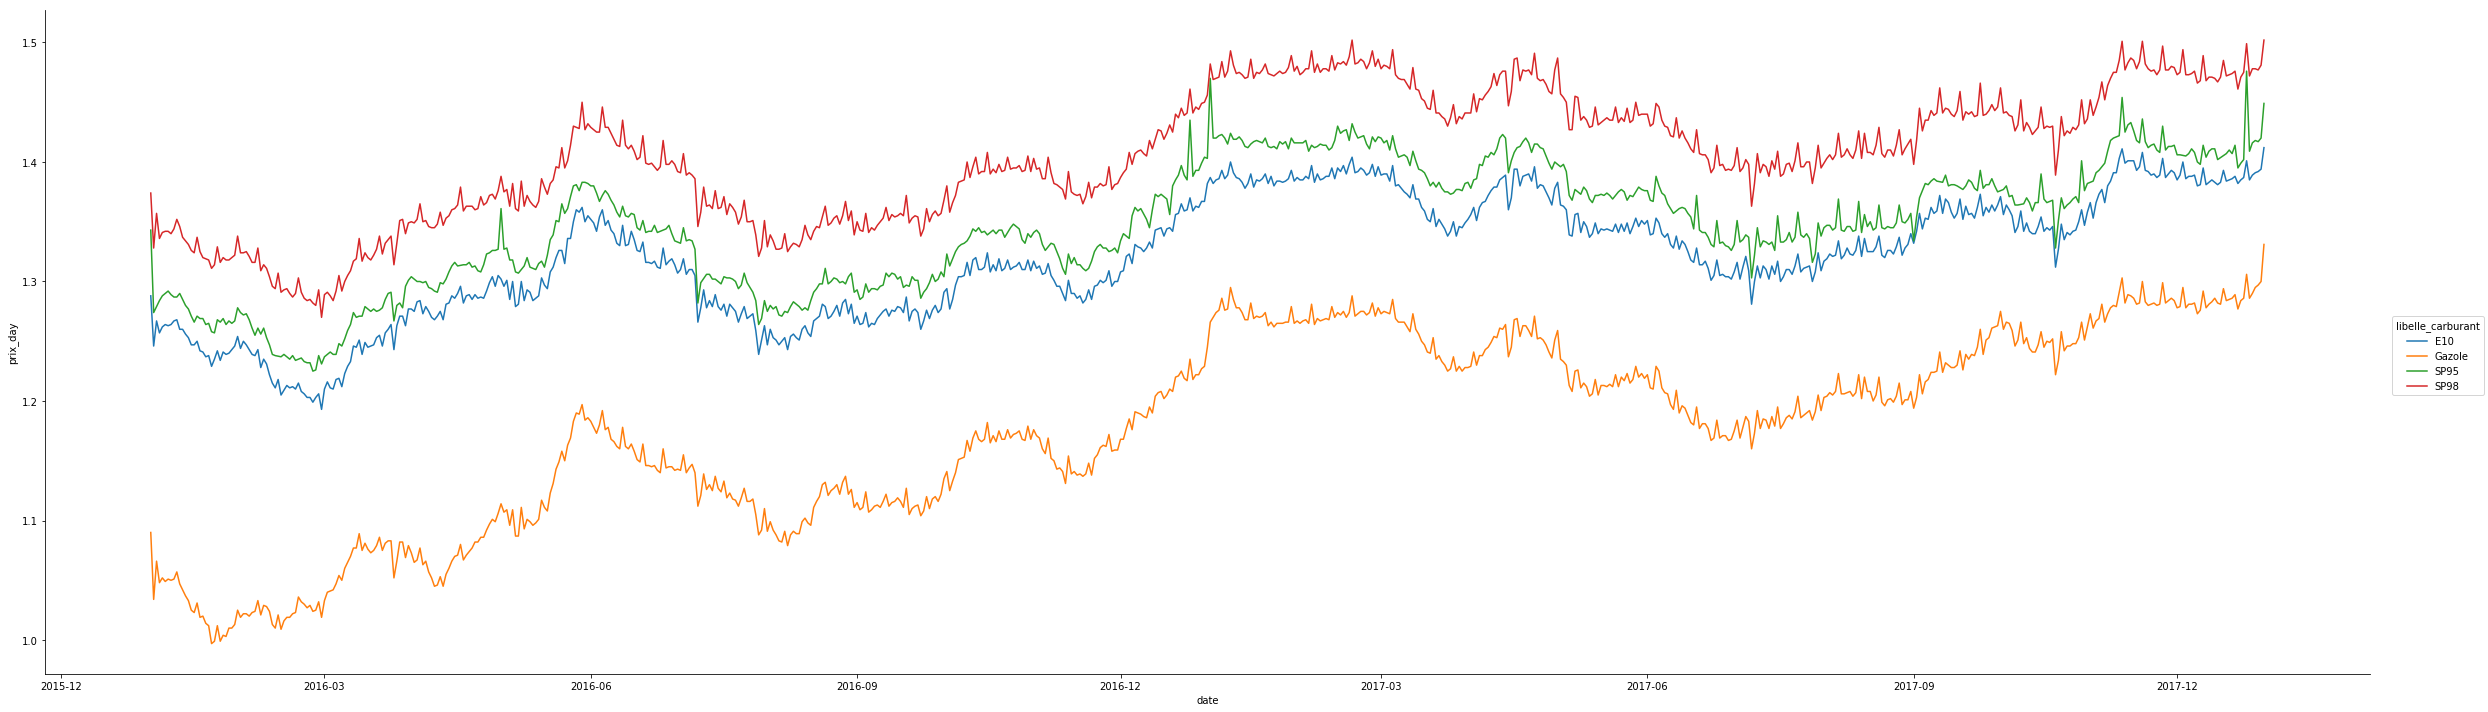

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

graph = sns.FacetGrid(avg_price[~avg_price.libelle_carburant.isin(['GPLc', 'E85'])].sort_values(by=['libelle_carburant', 'date']), hue='libelle_carburant',
                      size=10,aspect=80/24) 
graph.map(plt.plot, "date", "prix_day")
graph.add_legend()

On peut voir que les prix évoluent de la même manière selon le type d'essence. On peut aussi observer que les augmentations sont plus rapide et les prix mettent plus de temps à rediminuer. Sinon de façon global les prix ont augmenté de 2016 à 2018 pour le gazole passant de 1.10 € à environ 1.20€.

## Data Visualization 2

In [41]:
# modify int in string
spark.sql(
    'SELECT id_station, code_postal, CAST( code_postal AS string ) as code_postal_char, libelle_carburant, date, prix_day,indice_base100, indice '
    'FROM price_index_stations '
    'WHERE ').cache().createOrReplaceTempView('price_index_stations_2')

In [42]:
# add 0 code_postal_char 
spark.sql(
    'SELECT id_station, code_postal, IF(code_postal < 10000, CONCAT( \'0\', code_postal_char ),code_postal_char) as code_postal_char, libelle_carburant, date, prix_day,indice_base100, indice '
    'FROM price_index_stations_2 ').cache().createOrReplaceTempView('price_index_stations_3')

In [43]:
spark.sql(
    'SELECT code_postal_char,LEFT(code_postal_char, 2) as department, libelle_carburant, avg(indice) as avg_price_index, avg(indice_base100) as avg_price_index_100 '
    'FROM price_index_stations_3 '
    'GROUP BY code_postal_char, libelle_carburant ').cache().createOrReplaceTempView('avg_dep_price_index_stations')

In [44]:
spark.catalog.uncacheTable('data_1')
spark.catalog.uncacheTable('data_station')
spark.catalog.uncacheTable('station_by_addr')
spark.catalog.uncacheTable('avg_dep_price_index_stations')

In [45]:
df_avg_dep_price = spark.sql(
    'SELECT department, libelle_carburant, avg_price_index, avg_price_index_100 ' 
    'FROM avg_dep_price_index_stations '
).toPandas()

In [46]:
df_avg_dep_price

department libelle_carburant  avg_price_index  avg_price_index_100
0             11               E10         0.990813           100.963977
1             33               E10         1.042662            95.988074
2             31               E10         0.961095           104.065542
3             33               E10         0.970873           103.005072
4             41               E10         0.985145           101.597171
5             61               E10         0.981323           101.938844
6             54               E10         1.083624            92.520140
7             92               E85         1.079449            92.657153
8             77              GPLc         0.945084           106.382618
9             78              GPLc         1.025521            97.580190
10            08            Gazole         1.032753            97.031026
11            94            Gazole         0.982721           101.834773
12            76            Gazole         0.979179           102.273990
13            42            Gazole         1.014062            98.873752
14            17            Gazole         0.959219           104.268799
15            17            Gazole         0.967516           103.492814
16            87            Gazole         1.015247            98.581903
17            29            Gazole         0.960495           104.124744
18            50            Gazole         0.974158           102.660299
19            42            Gazole         1.035105            96.713885
20            27            Gazole         0.998369           100.311886
21            50            Gazole         0.972593           102.825419
22            16              SP95         0.974784           102.598689
23            71              SP95         1.021617            97.980202
24            25              SP95         0.985860           101.458246
25            01              SP95         0.996352           100.388633
26            70              SP95         1.028791            97.240014
27            34              SP95         0.996893           100.339748
28            29              SP95         0.988471           101.187888
29            95              SP98         1.065288            94.069853
...          ...               ...              ...                  ...
17207         36              SP98         1.113626            89.812707
17208         14              SP98         0.976399           102.426221
17209         53              SP98         1.015123            98.655712
17210         59               E10         0.974288           102.677574
17211         60               E10         0.968967           103.223594
17212         54               E10         1.051355            95.119776
17213         30               E10         0.995422           100.587439
17214         59              SP98         1.065011            93.908741
17215         67              SP98         0.978122           102.269310
17216         40              SP98         0.995564           100.468103
17217         93               E85         1.029676            97.166473
17218         34            Gazole         1.019462            98.189085
17219         20              SP95         1.075985            92.967566
17220         50              SP98         1.074140            93.108797
17221         62               E85         1.024185           101.132307
17222         80              SP98         0.990144           101.003499
17223         95               E10         1.073169            93.207425
17224         35              SP95         0.993822           100.634894
17225         91              SP95         1.018893            98.225592
17226         66              SP95         1.007662            99.260357
17227         35               E85         1.041196            96.080945
17228         33              GPLc         0.989580           101.105144
17229         40               E10         0.983415           10

In [47]:
import pygal.maps.fr # librairy pour créer la map

from IPython.display import SVG # librairie pour l'afficher dans le notebook
import pandas as pd 
import numpy as np

html_pygal = """
<!DOCTYPEg>
<html>
  <head>
    <script type="text/javascript" src="http://kozea.github.com/pygal.js/latest/pygal-tooltips.min.js"></script>
    <!-- ... -->
  </head>
  <body>
    <figure>
      {0}
    </figure>
  </body>
</html>
"""

from IPython.display import HTML

In [48]:
avg_price_SP95 = df_avg_dep_price.where(df_avg_dep_price['libelle_carburant'] == 'SP95')
avg_price_SP95.dropna(inplace=True)
avg_price_SP95

department libelle_carburant  avg_price_index  avg_price_index_100
22            16              SP95         0.974784           102.598689
23            71              SP95         1.021617            97.980202
24            25              SP95         0.985860           101.458246
25            01              SP95         0.996352           100.388633
26            70              SP95         1.028791            97.240014
27            34              SP95         0.996893           100.339748
28            29              SP95         0.988471           101.187888
38            72              SP95         0.992297           100.786137
39            81              SP95         1.001319            99.898239
40            32              SP95         1.001464            99.864251
41            58              SP95         1.002458            99.768131
42            34              SP95         0.991015           100.999363
43            36              SP95         1.010419            99.008091
60            63              SP95         1.004571            99.553978
66            35              SP95         1.022492            97.813432
68            04              SP95         1.047934            95.473668
92            34              SP95         0.988787           101.152391
93            90              SP95         1.015744            98.532904
94            93              SP95         0.992688           100.747823
95            28              SP95         1.012140            98.914663
96            59              SP95         0.990965           100.928138
105           26              SP95         1.009351            99.101115
106           80              SP95         1.014599            98.577845
107           33              SP95         0.993735           100.642602
118           87              SP95         0.995239           100.495877
119           12              SP95         1.004128            99.604594
120           16              SP95         0.993196           100.703508
124           33              SP95         1.031341            97.292648
128           53              SP95         1.009346            99.261652
129           38              SP95         1.067277            93.704930
...          ...               ...              ...                  ...
17124         82              SP95         1.031413            97.008319
17125         38              SP95         1.004456            99.570800
17126         33              SP95         1.012306            98.920302
17127         93              SP95         0.993168           100.694607
17138         63              SP95         1.028082            97.291142
17143         51              SP95         1.004074            99.604876
17148         36              SP95         0.984091           101.625979
17174         49              SP95         0.999378           100.079121
17175         83              SP95         0.992685           100.787831
17176         04              SP95         0.996172           100.405776
17177         10              SP95         0.983182           101.717954
17178         87              SP95         0.991727           100.906271
17179         67              SP95         1.035739            96.728848
17180         68              SP95         1.012386            98.882853
17181         58              SP95         0.995539           100.506850
17182         85              SP95         0.980449           102.002067
17183         55              SP95         1.028922            97.422228
17184         32              SP95         1.029049            97.296957
17185         10              SP95         0.999627           100.059837
17200         11              SP95         0.991209           100.898037
17201         50              SP95         0.987198           101.311573
17202         28              SP95         0.983751           101.662615
17203         13              SP95         1.077515            9

In [49]:
m = df_avg_dep_price['libelle_carburant'].unique()
n = [i for i in m]
n

['E10', 'E85', 'GPLc', 'Gazole', 'SP95', 'SP98']

In [50]:
def avg_price_gas_type(gas):
    avg_price = df_avg_dep_price.where(df_avg_dep_price['libelle_carburant'] == gas)
    avg_price.dropna(inplace=True)
    return avg_price

In [51]:
df_SP95 = avg_price_gas_type('SP95') # df pour chaque type de gas
df_Gazole = avg_price_gas_type('Gazole')
df_SP98 = avg_price_gas_type('SP98')
df_E10 = avg_price_gas_type('E10')
df_GPLc = avg_price_gas_type('GPLc')
df_E85 = avg_price_gas_type('E85')

In [52]:
### pour mettre dans fr_chart.add
# Mettre dans un format spécifique pour l'utiliser pour faire la carte
dic_SP95= dict([(i,b) for i,b in zip(df_SP95.department, df_SP95.avg_price_index)])
dic_Gazole= list([(i,b) for i,b in zip(df_Gazole.department, df_Gazole.avg_price_index)])
dic_SP98= list([(i,b) for i,b in zip(df_SP98.department, df_SP98.avg_price_index)])
dic_E10= list([(i,b) for i,b in zip(df_E10.department, df_E10.avg_price_index)])
dic_GPLc= list([(i,b) for i,b in zip(df_GPLc.department, df_GPLc.avg_price_index)])
dic_E85= list([(i,b) for i,b in zip(df_E85.department, df_E85.avg_price_index)])

In [53]:
fr_chart_SP95 = pygal.maps.fr.Departments(human_readable=True)

fr_chart_SP95 = pygal.maps.fr.Departments(human_readable=True)
fr_chart_SP95.title = 'Average price by department for SP95'
fr_chart_SP95.add('SP95', dic_SP95)
svg_SP95 = fr_chart_SP95.render()


HTML(html_pygal.format(svg_SP95.decode("utf-8")))

In [54]:
fr_chart_SP98 = pygal.maps.fr.Departments(human_readable=True)

fr_chart_SP98 = pygal.maps.fr.Departments(human_readable=True)
fr_chart_SP98.title = 'Average price by department for SP98'
fr_chart_SP98.add('SP98', dic_SP98)
svg_SP98 = fr_chart_SP98.render()


HTML(html_pygal.format(svg_SP98.decode("utf-8")))

In [55]:
fr_chart_Gazole = pygal.maps.fr.Departments(human_readable=True)

fr_chart_Gazole = pygal.maps.fr.Departments(human_readable=True)
fr_chart_Gazole.title = 'Average price by department for Gazole'
fr_chart_Gazole.add('Gazole', dic_Gazole)
svg_Gazole = fr_chart_Gazole.render()


HTML(html_pygal.format(svg_Gazole.decode("utf-8")))

In [56]:
fr_chart_GPLc = pygal.maps.fr.Departments(human_readable=True)

fr_chart_GPLc = pygal.maps.fr.Departments(human_readable=True)
fr_chart_GPLc.title = 'Average price by department for GPLc'
fr_chart_GPLc.add('GPLc', dic_GPLc)
svg_GPLc = fr_chart_GPLc.render()


HTML(html_pygal.format(svg_GPLc.decode("utf-8")))

In [57]:
fr_chart_E10 = pygal.maps.fr.Departments(human_readable=True)

fr_chart_E10 = pygal.maps.fr.Departments(human_readable=True)
fr_chart_E10.title = 'Average price by department for E10'
fr_chart_E10.add('E10', dic_E10)
svg_E10 = fr_chart_E10.render()


HTML(html_pygal.format(svg_E10.decode("utf-8")))

In [58]:
fr_chart_E85 = pygal.maps.fr.Departments(human_readable=True)

fr_chart_E85 = pygal.maps.fr.Departments(human_readable=True)
fr_chart_E85.title = 'Average price by department for E85'
fr_chart_E85.add('E85', dic_E85)
svg_E85 = fr_chart_E85.render()


HTML(html_pygal.format(svg_E85.decode("utf-8")))

# OPTION 1 - Forecast next day price
## Avec fichier services 2017
Dans cette section, nous avons essayer de prendre en compte les services présents dans chaque station et les lag des prix pour faire notre prédiction, mais nous n'avons pas pu aboutir car nous avions un problème "NonType" que nous n'arrivions pas à résoudre.

In [63]:
services_ddf = (spark.read.load('/Users/fannydouchet/Desktop/Homework_bigdata/Services2017.csv',
                                format='csv', sep='|', header='false', interSchema='true')
                .selectExpr(
                    '_c0 as id_station',
                    '_c1 as code_postal',
                    '_c2 as type_station',
                    '_c3 as latitude',
                    '_c4 as longitude',
                    '_c5 as services'
                )
                .dropna(subset=['services']) #enlève les missing values, seulement sur la colonne services
                .cache()
               )

In [64]:
sqlsc.registerDataFrameAsTable(services_ddf, 'services_ddf')

In [65]:
df_merge = (spark.sql("SELECT * FROM table_mapping, services_ddf "
          "WHERE table_mapping.station_id = services_ddf.id_station")).toPandas()

In [66]:
df_merge.head()

unique_ID  station_id id_station code_postal type_station       latitude  \
0   52100015    51120004   51120004       51120            R        4872683   
1   52100015    52100017   52100017       52100            R    4864247.032   
2   52100015    52100015   52100015       52100            R        4864725   
3   27950001    76220002   76220002       76220            R  4949035.07864   
4   27950001    27460002   27460002       27460            R          1.158   

       longitude                                           services  
0         367583  Restauration à emporter,Carburant qualité supé...  
1     490260.894  Restauration à emporter,Carburant qualité supé...  
2         486815  Restauration à emporter,Carburant qualité supé...  
3  169240.380972  Carburant qualité supérieure,Boutique alimenta...  
4         49.312  Carburant qualité supérieure,Boutique alimenta...

In [67]:
df_merge = (spark.sql("SELECT * FROM table_mapping, services_ddf "
          "WHERE table_mapping.station_id = services_ddf.id_station")).cache().createOrReplaceTempView('df_merge')

In [68]:
avg_price

unique_ID  id_station  code_postal libelle_carburant        date  \
0        1000008     1000008         1000              SP95  2017-10-16   
1        1000013     1000013         1000            Gazole  2017-08-11   
2        1000009     1000009         1000               E10  2016-03-07   
3        1000013     1000013         1000               E10  2016-05-20   
4        1000001     1000001         1000              SP95  2017-07-12   
5        1000013     1000013         1000            Gazole  2017-03-01   
6        1000008     1000008         1000              SP98  2016-06-23   
7        1000008     1000008         1000            Gazole  2016-01-27   
8        1000007     1000007         1000            Gazole  2017-10-17   
9        1000006     1000006         1000              SP95  2017-01-13   
10       1000013     1000013         1000            Gazole  2017-08-17   
11       1000012     1000012         1000               E10  2016-09-21   
12       1000012     1000012         1000               E10  2017-07-22   
13       1000012     1000012         1000            Gazole  2016-06-11   
14       1000012     1000012         1000               E10  2017-08-27   
15       1000013     1000013         1000            Gazole  2017-02-26   
16       1000013     1000013         1000              SP98  2017-10-31   
17       1000013     1000013         1000              SP98  2016-09-20   
18       1000002     1000002         1000            Gazole  2016-06-05   
19       1000009     1000009         1000            Gazole  2017-09-12   
20       1000001     1000001         1000              SP95  2016-01-30   
21       1000004     1000004         1000            Gazole  2016-11-30   
22       1000012     1000012         1000            Gazole  2016-06-20   
23       1000012     1000012         1000              SP98  2017-07-02   
24       1000006     1000006         1000            Gazole  2016-10-11   
25       1000009     1000009         1000               E10  2016-01-20   
26       1000008     1000008         1000            Gazole  2016-08-15   
27       1000013     1000013         1000              SP98  2016-02-19   
28       1000012     1000012         1000               E10  2016-07-08   
29       1000008     1000008         1000               E10  2016-09-02   
...          ...         ...          ...               ...         ...   
11281    1000008     1000008         1000              SP95  2017-12-05   
11282    1000013     1000013         1000              SP98  2017-06-18   
11283    1000001     1000001         1000            Gazole  2017-01-31   
11284    1000009     1000009         1000            Gazole  2017-07-31   
11285    1000008     1000008         1000              SP95  2017-09-28   
11286    1000001     1000001         1000              SP95  2016-11-02   
11287    1000008     1000008         1000            Gazole  2017-08-19   
11288    1000001     1000001         1000            Gazole  2017-04-22   
11289    1000002     1000002         1000              SP95  2016-08-05   
11290    1000009     1000009         1000              SP98  2017-09-07   
11291    1000012     1000012         1000               E10  2017-08-11   
11292    1000008     1000008         1000              SP95  2016-07-01   
11293    1000007     1000007         1000              SP95  2017-01-24   
11294    1000002     1000002         1000            Gazole  2016-06-10   
11295    1000008     1000008         1000              SP98  2017-06-15   
11296    1000012     1000012         1000               E10  2017-10-15   
11297    1000008     1000008         1000            Gazole  2016-04-24   
11298    1000002     1000002         1000              SP98  2017-09-06   
11299    1000006     1000006         1000              SP95  2016-08-11   
11300    1000013     1000013         1000            Gazole  2017-07-29   
11301    1000012     1000012         1000            Gazole  2016-01-16   
11302    1000001     1000001    

In [69]:
avg_price_1 = spark.sql(
    'SELECT * '
    'FROM average_day_price_sample '
    'WHERE prix_day > 0.8 AND prix_day < 1.8 '
).cache().createOrReplaceTempView('avg_price_1')

In [70]:
service_merge = spark.sql(
    'SELECT avg_price_1.unique_ID, avg_price_1.id_station, libelle_carburant, date, prix_day, services '
    'FROM avg_price_1, df_merge '
    'WHERE avg_price_1.id_station=df_merge.id_station'
).cache().createOrReplaceTempView('service_merge')

In [71]:
opt_SP95 = sqlsc.sql('SELECT * from service_merge WHERE libelle_carburant = "SP95" order by date asc ').cache()

#### Création des lag sur les prix

In [72]:
from pyspark.sql.functions import monotonically_increasing_id, lag
from pyspark.sql.window import Window

In [73]:
# Add ID to be used by the window function
opt_SP95 = opt_SP95.withColumn('id', monotonically_increasing_id())
# Set the window
w = Window.orderBy("id")
# Create the lagged value -1
value_lag = lag('prix_day').over(w)
# Add the lagged values to a new column
opt_SP95 = opt_SP95.withColumn('prix_day_lag_1', value_lag)

# Create the lagged value -2
value_lag = lag('prix_day_lag_1').over(w)
# Add the lagged values to a new column
opt_SP95 = opt_SP95.withColumn('prix_day_lag_2', value_lag)

# Create the lagged value -3
value_lag = lag('prix_day_lag_2').over(w)
# Add the lagged values to a new column
opt_SP95 = opt_SP95.withColumn('prix_day_lag_3', value_lag)

# Create the lagged value -4
value_lag = lag('prix_day_lag_3').over(w)
# Add the lagged values to a new column
opt_SP95 = opt_SP95.withColumn('prix_day_lag_4', value_lag)

# Create the lagged value -5
value_lag = lag('prix_day_lag_4').over(w)
# Add the lagged values to a new column
opt_SP95 = opt_SP95.withColumn('prix_day_lag_5', value_lag)

# Create the lagged value -6
value_lag = lag('prix_day_lag_5').over(w)
# Add the lagged values to a new column
opt_SP95 = opt_SP95.withColumn('prix_day_lag_6', value_lag)

In [74]:
sqlsc.registerDataFrameAsTable(opt_SP95, 'opt_SP95')

In [75]:
opt_SP95_new = spark.sql(
    'SELECT * FROM opt_SP95 '
    'WHERE prix_day_lag_6 IS NOT NULL '
).cache().createOrReplaceTempView('opt_SP95_new')

## Pipeline pour transformer la colonne services en dummies variables

In [76]:
from pyspark.ml.feature import RegexTokenizer
from pyspark.ml.feature import CountVectorizer
from pyspark.ml.pipeline import Pipeline
from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StandardScaler
from pyspark.sql.functions import *

In [77]:
#Description du pipeline
tronconneuse = RegexTokenizer(inputCol='services', outputCol='liste_services', pattern=',')
vectorizer = CountVectorizer(inputCol='liste_services', outputCol='vecteur_services', binary=True)
my_pipeline = Pipeline(stages=[tronconneuse, vectorizer])

In [78]:
vecteur_services_ddf = (my_pipeline
                        .fit(services_ddf)
                        .transform(services_ddf)
                        .cache()
                        .createOrReplaceTempView('vecteur_services'))

In [79]:
#Il faut faire une jointure entre cette table et la table des indices de prix
spark.sql('SELECT * '
          'FROM opt_SP95_new, vecteur_services '
          'WHERE opt_SP95_new.id_station = vecteur_services.id_station'
).cache().createOrReplaceTempView('table')

In [81]:
table_1 = spark.sql(
    'SELECT unique_ID, libelle_carburant, prix_day, date, prix_day_lag_1,prix_day_lag_2, prix_day_lag_3, prix_day_lag_4, prix_day_lag_5, prix_day_lag_6, vecteur_services '
    'FROM table '
).toPandas()

In [82]:
table_1

unique_ID libelle_carburant  prix_day        date  prix_day_lag_1  \
0       1000008              SP95     1.274  2016-01-02           1.274   
1       1000007              SP95     1.284  2016-01-04           1.274   
2       1000001              SP95     1.284  2016-01-04           1.284   
3       1000002              SP95     1.284  2016-01-04           1.284   
4       1000008              SP95     1.284  2016-01-04           1.284   
5       1000008              SP95     1.284  2016-01-04           1.284   
6       1000001              SP95     1.288  2016-01-05           1.284   
7       1000008              SP95     1.288  2016-01-05           1.288   
8       1000008              SP95     1.288  2016-01-05           1.288   
9       1000006              SP95     1.290  2016-01-06           1.288   
10      1000008              SP95     1.290  2016-01-06           1.290   
11      1000008              SP95     1.290  2016-01-06           1.290   
12      1000001              SP95     1.292  2016-01-07           1.290   
13      1000008              SP95     1.292  2016-01-07           1.292   
14      1000008              SP95     1.292  2016-01-07           1.292   
15      1000001              SP95     1.289  2016-01-08           1.292   
16      1000002              SP95     1.289  2016-01-08           1.289   
17     64100008              SP95     1.289  2016-01-08           1.289   
18     64100008              SP95     1.289  2016-01-08           1.289   
19     64100008              SP95     1.289  2016-01-08           1.289   
20     64100008              SP95     1.289  2016-01-08           1.289   
21      1000004              SP95     1.289  2016-01-08           1.289   
22      1000004              SP95     1.289  2016-01-08           1.289   
23      1000004              SP95     1.289  2016-01-08           1.289   
24      1000004              SP95     1.289  2016-01-08           1.289   
25      1000008              SP95     1.289  2016-01-08           1.289   
26      1000008              SP95     1.289  2016-01-08           1.289   
27      1000001              SP95     1.287  2016-01-09           1.289   
28      1000008              SP95     1.287  2016-01-09           1.287   
29      1000008              SP95     1.287  2016-01-09           1.287   
...         ...               ...       ...         ...             ...   
3212    1000008              SP95     1.399  2017-12-23           1.399   
3213    1000008              SP95     1.402  2017-12-24           1.399   
3214    1000008              SP95     1.402  2017-12-24           1.402   
3215    1000008              SP95     1.476  2017-12-25           1.402   
3216    1000008              SP95     1.476  2017-12-25           1.476   
3217    1000008              SP95     1.409  2017-12-26           1.476   
3218    1000008              SP95     1.409  2017-12-26           1.409   
3219    1000008              SP95     1.416  2017-12-27           1.409   
3220    1000008              SP95     1.416  2017-12-27           1.416   
3221    1000007              SP95     1.418  2017-12-28           1.416   
3222    1000001              SP95     1.418  2017-12-28           1.418   
3223    1000009              SP95     1.418  2017-12-28           1.418   
3224    1000002              SP95     1.418  2017-12-28           1.418   
3225    1000008              SP95     1.418  2017-12-28           1.418   
3226    1000008              SP95     1.418  2017-12-28           1.418   
3227    1000007              SP95     1.417  2017-12-29           1.418   
3228    1000001              SP95     1.417  2017-12-29           1.417   
3229    1000009              SP95     1.417  2017-12-29           1.417   
3230    1000002              SP95     1.417  2017-12-29           1.417   
3231    1000008              SP95     1.417  2017-12-29           1.417   
3232    1000008              SP95     1.417  2017-12-29           1.417   
3233    1000007              SP

In [83]:
table_1 = spark.sql(
    'SELECT unique_ID, libelle_carburant, prix_day, date, prix_day_lag_1,prix_day_lag_2, prix_day_lag_3, prix_day_lag_4, prix_day_lag_5, prix_day_lag_6, vecteur_services '
    'FROM table '
).cache().createOrReplaceTempView('table_1')

## Erreur rencontrée à ce niveau

In [84]:
vectorAssembler = VectorAssembler(inputCols = ["prix_day_lag_1", "prix_day_lag_2", "prix_day_lag_3", "prix_day_lag_4", "prix_day_lag_5", "prix_day_lag_6"], outputCol = 'features')
opt_SP95_df = vectorAssembler.transform(table_1)
opt_SP95_df = opt_SP95_df.select(['features', 'prix_day'])
opt_SP95_df.show(3)

AttributeError: 'NoneType' object has no attribute '_jdf'

# Option 1 - Forecast next day price
## Sans les services
Nous avons alors seulement considéré les lag sur les indices des prix pour faire notre prédiction

## Pipeline pour SP95

In [86]:
table = spark.sql(
    'SELECT * '
    'FROM average_day_price_sample '
).cache()

In [87]:
sqlsc.registerDataFrameAsTable(table, 'table')

In [88]:
table_features_SP95 = spark.sql('SELECT * '
          'FROM table '
          'WHERE libelle_carburant = "SP95" '
          'ORDER BY unique_ID, date, libelle_carburant'
).cache()

In [89]:
from pyspark.sql.functions import monotonically_increasing_id, lag
from pyspark.sql.window import Window
# Add ID to be used by the window function
table_features_SP95 = table_features_SP95.withColumn('id', monotonically_increasing_id())
# Set the window
w = Window.orderBy("id")
# Create the lagged value -1
value_lag = lag('indice_base100').over(w)
# Add the lagged values to a new column
table_features_SP95 = table_features_SP95.withColumn('indice_base100_lag_1', value_lag)

# Create the lagged value -2
value_lag = lag('indice_base100_lag_1').over(w)
# Add the lagged values to a new column
table_features_SP95 = table_features_SP95.withColumn('indice_base100_lag_2', value_lag)

# Create the lagged value -3
value_lag = lag('indice_base100_lag_2').over(w)
# Add the lagged values to a new column
table_features_SP95 = table_features_SP95.withColumn('indice_base100_lag_3', value_lag)

# Create the lagged value -4
value_lag = lag('indice_base100_lag_3').over(w)
# Add the lagged values to a new column
table_features_SP95 = table_features_SP95.withColumn('indice_base100_lag_4', value_lag)

# Create the lagged value -5
value_lag = lag('indice_base100_lag_4').over(w)
# Add the lagged values to a new column
table_features_SP95 = table_features_SP95.withColumn('indice_base100_lag_5', value_lag)

# Create the lagged value -6
value_lag = lag('indice_base100_lag_5').over(w)
# Add the lagged values to a new column
table_features_SP95 = table_features_SP95.withColumn('indice_base100_lag_6', value_lag)

In [90]:
sqlsc.registerDataFrameAsTable(table_features_SP95, 'table_features_SP95')

In [91]:
table_features_new_SP95 = spark.sql(
    'SELECT * FROM table_features_SP95 '
    'WHERE indice_base100_lag_6 IS NOT NULL '
).cache()

In [92]:
sqlsc.registerDataFrameAsTable(table_features_new_SP95, 'table_features_new_SP95')

In [93]:
from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StandardScaler
from pyspark.ml import Pipeline
from pyspark.sql.functions import *

features = ["indice_base100_lag_1", "indice_base100_lag_2", "indice_base100_lag_3", "indice_base100_lag_4", "indice_base100_lag_5", "indice_base100_lag_6"]

vectorAssembler = VectorAssembler(inputCols=features, outputCol="features")
standardScaler = StandardScaler(inputCol="unscaled_features", outputCol="features")
lr = LinearRegression(featuresCol = 'features', labelCol='prix_day', maxIter=10, regParam=0.3, elasticNetParam=0.8)

mypipeline = Pipeline(stages=[vectorAssembler, lr])

pip_SP95 = (mypipeline
            .fit(table_features_new_SP95)
            .transform(table_features_new_SP95)
            .cache()
            .createOrReplaceTempView('pipeline_SP95'))

In [94]:
pip_SP95= sqlsc.sql('SELECT * FROM pipeline_SP95').toPandas()

In [95]:
lr_model = lr.fit(pip_SP95)
print("Coefficients: " + str(lr_model.coefficients))
print("Intercept: " + str(lr_model.intercept))

AttributeError: 'DataFrame' object has no attribute '_jdf'

# Problème:
Nous n'arrivons pas à continuer la prédiction lorsque nous utilisons le Pipeline. En effet, nous n'arrivons pas à comprendre comment insérer l'étape du "split" de nos données en training set et en test set.
Cette étape de split se situe entre l'étape de transformation et la régréssion linéaire, c'est pourquoi il nous a parut étrange de faire deux pipelines différents avant et après l'étape du split de nos données. 

# Prédiction sans pipeline
Notre modèle est :
$$ indice_t = \sum_{i=1}^{N}\alpha_{i}indice_{t-i} $$
Avec $\alpha_{i}$ l'impact de l'indice enregistré à la date t-i sur l'indice à la date t
## SP95

In [157]:
table = spark.sql(
    'SELECT * '
    'FROM average_day_price_sample '
).cache()
sqlsc.registerDataFrameAsTable(table, 'table')

In [158]:
sqlsc.registerDataFrameAsTable(table, 'table')

In [159]:
table_features_SP95 = spark.sql('SELECT * '
          'FROM table '
          'WHERE libelle_carburant = "SP95" '
          'ORDER BY unique_ID, date, libelle_carburant'
).cache()

In [160]:
from pyspark.sql.functions import monotonically_increasing_id, lag
from pyspark.sql.window import Window
# Add ID to be used by the window function
table_features_SP95 = table_features_SP95.withColumn('id', monotonically_increasing_id())
# Set the window
w = Window.orderBy("id")
# Create the lagged value -1
value_lag = lag('indice_base100').over(w)
# Add the lagged values to a new column
table_features_SP95 = table_features_SP95.withColumn('indice_base100_lag_1', value_lag)

# Create the lagged value -2
value_lag = lag('indice_base100_lag_1').over(w)
# Add the lagged values to a new column
table_features_SP95 = table_features_SP95.withColumn('indice_base100_lag_2', value_lag)

# Create the lagged value -3
value_lag = lag('indice_base100_lag_2').over(w)
# Add the lagged values to a new column
table_features_SP95 = table_features_SP95.withColumn('indice_base100_lag_3', value_lag)

# Create the lagged value -4
value_lag = lag('indice_base100_lag_3').over(w)
# Add the lagged values to a new column
table_features_SP95 = table_features_SP95.withColumn('indice_base100_lag_4', value_lag)

# Create the lagged value -5
value_lag = lag('indice_base100_lag_4').over(w)
# Add the lagged values to a new column
table_features_SP95 = table_features_SP95.withColumn('indice_base100_lag_5', value_lag)

# Create the lagged value -6
value_lag = lag('indice_base100_lag_5').over(w)
# Add the lagged values to a new column
table_features_SP95 = table_features_SP95.withColumn('indice_base100_lag_6', value_lag)

In [161]:
sqlsc.registerDataFrameAsTable(table_features_SP95, 'table_features_SP95')

In [162]:
table_features_new_SP95 = spark.sql(
    'SELECT * FROM table_features_SP95 '
    'WHERE indice_base100_lag_6 IS NOT NULL '
).cache()

In [163]:
sqlsc.registerDataFrameAsTable(table_features_new_SP95, 'table_features_new_SP95')

In [164]:
table_95 = sqlsc.sql('SELECT date, libelle_carburant, indice_base100, indice_base100_lag_1, indice_base100_lag_2, indice_base100_lag_3, indice_base100_lag_4, indice_base100_lag_5, indice_base100_lag_6 from table_features_new_SP95').toPandas()

In [165]:
table_95

date libelle_carburant  indice_base100  indice_base100_lag_1  \
0     2016-01-11              SP95       99.575453             99.459042   
1     2016-01-12              SP95       99.074788             99.575453   
2     2016-01-14              SP95       99.843628             99.074788   
3     2016-01-15              SP95       99.374511             99.843628   
4     2016-01-16              SP95       99.763593             99.374511   
5     2016-01-18              SP95      100.000000             99.763593   
6     2016-01-20              SP95      100.397141            100.000000   
7     2016-01-21              SP95      100.476569            100.397141   
8     2016-01-22              SP95      100.720576            100.476569   
9     2016-01-24              SP95      101.521217            100.720576   
10    2016-01-25              SP95      101.361089            101.521217   
11    2016-01-28              SP95      101.441153            101.361089   
12    2016-01-29              SP95      101.281025            101.441153   
13    2016-01-30              SP95      101.441153            101.281025   
14    2016-02-03              SP95      101.192369            101.441153   
15    2016-02-04              SP95      100.714853            101.192369   
16    2016-02-05              SP95      101.775626            100.714853   
17    2016-02-06              SP95      101.291364            101.775626   
18    2016-02-07              SP95      101.775626            101.291364   
19    2016-02-08              SP95      101.372074            101.775626   
20    2016-02-09              SP95      101.775626            101.372074   
21    2016-02-10              SP95      101.129944            101.775626   
22    2016-02-12              SP95      101.640689            101.129944   
23    2016-02-13              SP95      101.558655            101.640689   
24    2016-02-15              SP95      101.476620            101.558655   
25    2016-02-17              SP95      101.476620            101.476620   
26    2016-02-18              SP95      101.312551            101.476620   
27    2016-02-19              SP95      101.558655            101.312551   
28    2016-02-22              SP95      101.394586            101.558655   
29    2016-02-25              SP95      101.066448            101.394586   
...          ...               ...             ...                   ...   
2031  2017-04-05              SP95       93.758389             93.445946   
2032  2017-04-08              SP95       93.866667             93.758389   
2033  2017-04-13              SP95       94.039735             93.866667   
2034  2017-04-24              SP95       94.333333             94.039735   
2035  2017-04-28              SP95       94.527027             94.333333   
2036  2017-05-04              SP95       94.693878             94.527027   
2037  2017-05-10              SP95       95.763889             94.693878   
2038  2017-05-13              SP95       93.561644             95.763889   
2039  2017-05-23              SP95       94.965517             93.561644   
2040  2017-06-01              SP95       95.555556             94.965517   
2041  2017-06-10              SP95       96.241135             95.555556   
2042  2017-06-19              SP95       96.618705             96.241135   
2043  2017-07-06              SP95       94.154930             96.618705   
2044  2017-07-10              SP95       94.255319             94.154930   
2045  2017-07-11              SP95       94.609929             94.255319   
2046  2017-07-13              SP95       95.755396             94.609929   
2047  2017-07-22              SP95       94.822695             95.755396   
2048  2017-07-27              SP95       95.428571             94.822695   
2049  2017-08-05              SP95       94.718310             95.428571   
2050  2017-08-19              SP95       94.055944             94.718310   
2051  2017-09-04              SP95       93.605442          

In [166]:
from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StandardScaler
from pyspark.ml import Pipeline
from pyspark.sql.functions import *

vectorAssembler = VectorAssembler(inputCols = ["indice_base100_lag_1", "indice_base100_lag_2", "indice_base100_lag_3", "indice_base100_lag_4", "indice_base100_lag_5", "indice_base100_lag_6"], outputCol = 'features')
table_features_SP95 = vectorAssembler.transform(table_features_new_SP95)
table_features_SP95 = table_features_SP95.select(['features', 'indice_base100'])
table_features_SP95.show(3)

+--------------------+-----------------+
|            features|   indice_base100|
+--------------------+-----------------+
|[99.4590417310664...| 99.5754534928599|
|[99.5754534928599...|99.07478797224364|
|[99.0747879722436...|99.84362783424551|
+--------------------+-----------------+
only showing top 3 rows



In [167]:
splits = table_features_SP95.randomSplit([0.7, 0.3])
train_SP95 = splits[0]
test_SP95 = splits[1]

In [168]:
lr = LinearRegression(featuresCol = 'features', labelCol='indice_base100', maxIter=10, regParam=0.3, elasticNetParam=0.8)
lr_model = lr.fit(train_SP95)
print("Coefficients: " + str(lr_model.coefficients))
print("Intercept: " + str(lr_model.intercept))

Coefficients: [0.2356825379052173,0.1466951865563724,0.2429480278405262,0.0,0.17073380050749423,0.041796412676778645]
Intercept: 16.326387432807394


In [169]:
trainingSummary = lr_model.summary
print("RMSE: %f" % trainingSummary.rootMeanSquaredError)
print("r2: %f" % trainingSummary.r2)

RMSE: 1.088767
r2: 0.809854


In [170]:

lr_predictions = lr_model.transform(train_SP95)
lr_predictions.select("prediction","indice_base100","features").show(5)
from pyspark.ml.evaluation import RegressionEvaluator
lr_evaluator = RegressionEvaluator(predictionCol="prediction", \
                 labelCol="indice_base100",metricName="r2")
print("R Squared (R2) on test data = %g" % lr_evaluator.evaluate(lr_predictions))


+-----------------+-----------------+--------------------+
|       prediction|   indice_base100|            features|
+-----------------+-----------------+--------------------+
|93.55608245318183|92.44604316546763|[91.2318840579710...|
|93.55608245318183|92.44604316546763|[91.2318840579710...|
|94.07887277989157|91.77777777777779|[91.4925373134328...|
|94.04218702436982|93.03703703703702|[91.5107913669064...|
|93.81807630011329|91.23188405797102|[91.7777777777777...|
+-----------------+-----------------+--------------------+
only showing top 5 rows

R Squared (R2) on test data = 0.809854


In [171]:
predictions = lr_model.transform(test_SP95)
predictions.select("prediction","indice_base100","features").show()

+-----------------+-----------------+--------------------+
|       prediction|   indice_base100|            features|
+-----------------+-----------------+--------------------+
|94.07887277989157|91.77777777777779|[91.4925373134328...|
|94.09039223155987|93.03703703703702|[91.5107913669064...|
|93.81807630011329|91.23188405797102|[91.7777777777777...|
|94.56115557010517|93.81294964028778|[91.9858156028368...|
|93.65653228014513|94.66666666666667|[91.9867549668874...|
|94.14790811881349|92.22222222222223|[92.0979020979021...|
|94.14790811881349|92.22222222222223|[92.0979020979021...|
| 94.4343198457332| 92.5874125874126|[92.2222222222222...|
|95.52111764983145|91.51079136690649|[92.4087591240875...|
|95.72987515030007|91.51079136690649|[92.4087591240875...|
|94.10526667495904| 92.6530612244898|[92.4137931034482...|
|93.78587174366356|92.41379310344828|[92.5874125874126...|
|93.78587174366356|92.41379310344828|[92.5874125874126...|
|94.21470524541749|94.53237410071944|[92.6241134751773..

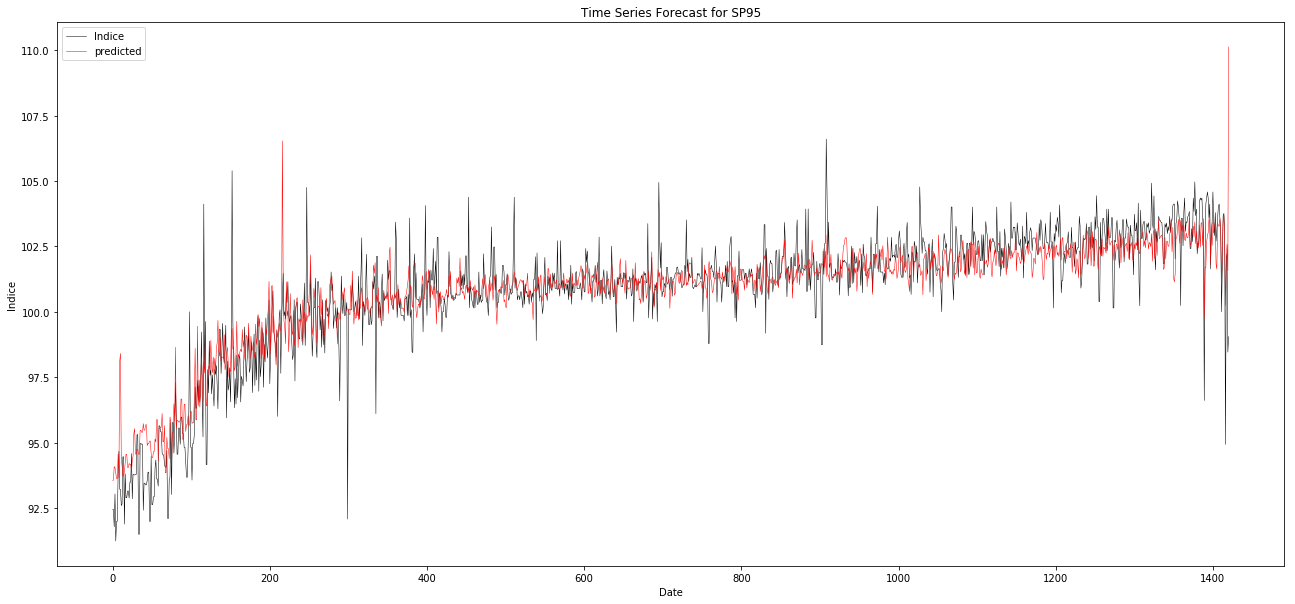

In [172]:
plt.figure(figsize=(22,10))

pr = trainingSummary.predictions.toPandas()

plt.plot(pr['indice_base100'],label = "Indice", linewidth=0.5, color = "black") # replace m by price
plt.plot(pr['prediction'],label = "predicted", linewidth=0.5, color = "red") # replace by the prediction values
plt.title("Time Series Forecast for SP95")
plt.xlabel("Date")
plt.ylabel("Indice")
plt.legend()

plt.show()

## Gazole

In [173]:
table_features_Gazole = spark.sql('SELECT * '
          'FROM table '
          'WHERE libelle_carburant = "Gazole" '
          'ORDER BY unique_ID, date, libelle_carburant'
).cache()

In [174]:
from pyspark.sql.functions import monotonically_increasing_id, lag
from pyspark.sql.window import Window

# Add ID to be used by the window function
table_features_Gazole = table_features_Gazole.withColumn('id', monotonically_increasing_id())
# Set the window
w = Window.orderBy("id")
# Create the lagged value -1
value_lag = lag('indice_base100').over(w)
# Add the lagged values to a new column
table_features_Gazole = table_features_Gazole.withColumn('indice_base100_lag_1', value_lag)

# Create the lagged value -2
value_lag = lag('indice_base100_lag_1').over(w)
# Add the lagged values to a new column
table_features_Gazole = table_features_Gazole.withColumn('indice_base100_lag_2', value_lag)

# Create the lagged value -3
value_lag = lag('indice_base100_lag_2').over(w)
# Add the lagged values to a new column
table_features_Gazole = table_features_Gazole.withColumn('indice_base100_lag_3', value_lag)

# Create the lagged value -4
value_lag = lag('indice_base100_lag_3').over(w)
# Add the lagged values to a new column
table_features_Gazole = table_features_Gazole.withColumn('indice_base100_lag_4', value_lag)

# Create the lagged value -5
value_lag = lag('indice_base100_lag_4').over(w)
# Add the lagged values to a new column
table_features_Gazole = table_features_Gazole.withColumn('indice_base100_lag_5', value_lag)

# Create the lagged value -6
value_lag = lag('indice_base100_lag_5').over(w)
# Add the lagged values to a new column
table_features_Gazole = table_features_Gazole.withColumn('indice_base100_lag_6', value_lag)


In [175]:
sqlsc.registerDataFrameAsTable(table_features_Gazole, 'table_features_Gazole')


In [176]:
table_features_new_Gazole = spark.sql(
    'SELECT * FROM table_features_Gazole '
    'WHERE indice_base100_lag_6 IS NOT NULL '
).cache()

In [177]:
sqlsc.registerDataFrameAsTable(table_features_new_Gazole, 'table_features_new_Gazole')

In [178]:
table_Gazole = sqlsc.sql('SELECT date, libelle_carburant, indice_base100, indice_base100_lag_1, indice_base100_lag_2, indice_base100_lag_3, indice_base100_lag_4, indice_base100_lag_5, indice_base100_lag_6 from table_features_new_Gazole').toPandas()

In [179]:
table_Gazole

date libelle_carburant  indice_base100  indice_base100_lag_1  \
0     2016-01-11            Gazole      102.848723            102.636719   
1     2016-01-12            Gazole      102.357564            102.848723   
2     2016-01-14            Gazole      102.378593            102.357564   
3     2016-01-15            Gazole      101.585728            102.378593   
4     2016-01-16            Gazole      102.402402            101.585728   
5     2016-01-18            Gazole      102.002002            102.402402   
6     2016-01-20            Gazole      102.631579            102.002002   
7     2016-01-21            Gazole      102.429150            102.631579   
8     2016-01-22            Gazole      101.942740            102.429150   
9     2016-01-24            Gazole      103.476483            101.942740   
10    2016-01-25            Gazole      102.147239            103.476483   
11    2016-01-28            Gazole      103.271984            102.147239   
12    2016-01-29            Gazole      103.271984            103.271984   
13    2016-01-30            Gazole      103.578732            103.271984   
14    2016-02-03            Gazole      103.441296            103.578732   
15    2016-02-04            Gazole      102.204409            103.441296   
16    2016-02-05            Gazole      102.505010            102.204409   
17    2016-02-06            Gazole      102.605210            102.505010   
18    2016-02-07            Gazole      103.507014            102.605210   
19    2016-02-08            Gazole      102.202202            103.507014   
20    2016-02-09            Gazole      103.003003            102.202202   
21    2016-02-10            Gazole      102.902903            103.003003   
22    2016-02-12            Gazole      101.401401            102.902903   
23    2016-02-13            Gazole      101.101101            101.401401   
24    2016-02-15            Gazole      101.001001            101.101101   
25    2016-02-17            Gazole      102.002002            101.001001   
26    2016-02-18            Gazole      102.002002            102.002002   
27    2016-02-19            Gazole      102.302302            102.002002   
28    2016-02-22            Gazole      103.303303            102.302302   
29    2016-02-25            Gazole      103.003003            103.303303   
...          ...               ...             ...                   ...   
3541  2017-04-08            Gazole       91.838235             91.703704   
3542  2017-04-13            Gazole       92.262774             91.838235   
3543  2017-04-18            Gazole       90.869565             92.262774   
3544  2017-04-24            Gazole       92.740741             90.869565   
3545  2017-04-28            Gazole       93.308271             92.740741   
3546  2017-05-04            Gazole       93.181818             93.308271   
3547  2017-05-10            Gazole       94.186047             93.181818   
3548  2017-05-13            Gazole       91.363636             94.186047   
3549  2017-06-01            Gazole       93.282443             91.363636   
3550  2017-06-06            Gazole       93.875969             93.282443   
3551  2017-06-10            Gazole       93.203125             93.875969   
3552  2017-06-19            Gazole       92.677165             93.203125   
3553  2017-07-06            Gazole       91.705426             92.677165   
3554  2017-07-13            Gazole       91.953125             91.705426   
3555  2017-07-22            Gazole       92.325581             91.953125   
3556  2017-07-27            Gazole       93.125000             92.325581   
3557  2017-08-05            Gazole       92.213740             93.125000   
3558  2017-08-21            Gazole       92.945736             92.213740   
3559  2017-09-04            Gazole       91.363636             92.945736   
3560  2017-09-08            Gazole       92.030075             91.363636   
3561  2017-09-14            Gazole       93.030303          

In [180]:
from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StandardScaler
from pyspark.ml import Pipeline
from pyspark.sql.functions import *

In [181]:
vectorAssembler = VectorAssembler(inputCols = ["indice_base100_lag_1", "indice_base100_lag_2", "indice_base100_lag_3", "indice_base100_lag_4", "indice_base100_lag_5", "indice_base100_lag_6"], outputCol = 'features')
table_features_Gazole = vectorAssembler.transform(table_features_new_Gazole)
table_features_Gazole = table_features_Gazole.select(['features', 'indice_base100'])
table_features_Gazole.show(3)

+--------------------+------------------+
|            features|    indice_base100|
+--------------------+------------------+
|[102.63671875,102...|102.84872298624754|
|[102.848722986247...|102.35756385068761|
|[102.357563850687...|102.37859266600596|
+--------------------+------------------+
only showing top 3 rows



In [182]:
splits = table_features_Gazole.randomSplit([0.7, 0.3])
train_Gazole = splits[0]
test_Gazole = splits[1]

In [183]:
lr = LinearRegression(featuresCol = 'features', labelCol='indice_base100', maxIter=10, regParam=0.3, elasticNetParam=0.8)
lr_model = lr.fit(train_Gazole)
print("Coefficients: " + str(lr_model.coefficients))
print("Intercept: " + str(lr_model.intercept))


Coefficients: [0.3747948361330964,0.22003546640853763,0.14544774017166823,0.06921734046285422,0.0713032502536491,0.04371106491140883]
Intercept: 7.544714016486604


In [184]:
trainingSummary = lr_model.summary
print("RMSE: %f" % trainingSummary.rootMeanSquaredError)
print("r2: %f" % trainingSummary.r2)

RMSE: 1.244946
r2: 0.918400


In [185]:
lr_predictions = lr_model.transform(train_Gazole)
lr_predictions.select("prediction","indice_base100","features").show(5)
from pyspark.ml.evaluation import RegressionEvaluator
lr_evaluator = RegressionEvaluator(predictionCol="prediction", \
                 labelCol="indice_base100",metricName="r2")
print("R Squared (R2) on test data = %g" % lr_evaluator.evaluate(lr_predictions))

+-----------------+------------------+--------------------+
|       prediction|    indice_base100|            features|
+-----------------+------------------+--------------------+
|87.30716701514801| 87.20588235294116|[79.3959731543624...|
|95.55440458907849|101.22914837576822|[86.0343539955190...|
|96.60353383046906|103.51985559566785|[86.7323730098559...|
|96.70608835068913|102.17917675544794|[87.0103092783505...|
|87.68066182056545| 88.86363636363637|[87.2058823529411...|
+-----------------+------------------+--------------------+
only showing top 5 rows

R Squared (R2) on test data = 0.9184


In [186]:
predictions = lr_model.transform(test_Gazole)
predictions.select("prediction","indice_base100","features").show()

+-----------------+-----------------+--------------------+
|       prediction|   indice_base100|            features|
+-----------------+-----------------+--------------------+
|87.30716701514801|87.20588235294116|[79.3959731543624...|
|87.68066182056545|88.86363636363637|[87.2058823529411...|
|88.29644873266292|90.78124999999999|[88.8636363636363...|
| 90.2445815555564|89.49579831932773|[89.0598290598290...|
|90.92086523818097|88.86956521739131|[89.3805309734513...|
| 98.2000110908825| 90.6140350877193|[89.7435897435897...|
|91.51575805668345|91.14754098360656|[89.9193548387096...|
|91.51575805668345|91.14754098360656|[89.9193548387096...|
|92.56419127943226|89.38053097345133|[89.9999999999999...|
|94.30072529100727|90.53571428571428|[90.6140350877193...|
|95.49061158914466|90.53571428571428|[90.6140350877193...|
| 96.4654283659336|93.50877192982458|[90.7017543859649...|
|90.74449964713617| 89.3859649122807|[90.7142857142857...|
|91.32763092641156|91.14754098360656|[90.7317073170731..

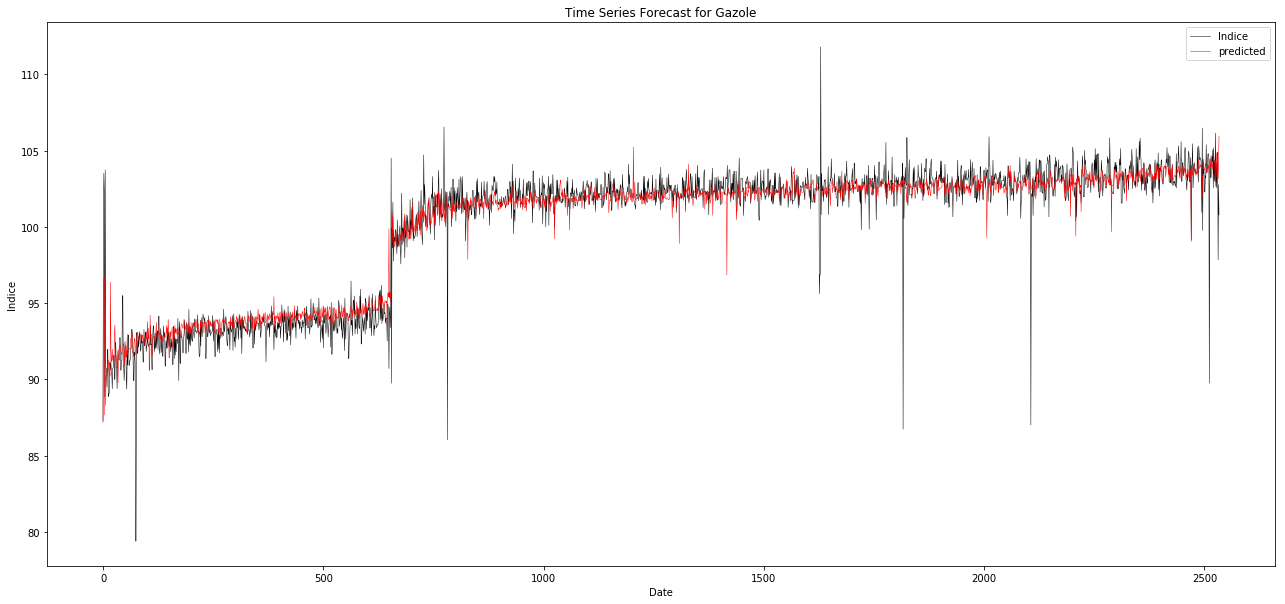

In [187]:
plt.figure(figsize=(22,10))

pr = trainingSummary.predictions.toPandas()

plt.plot(pr['indice_base100'],label = "Indice", linewidth=0.5, color = "black") # replace m by price
plt.plot(pr['prediction'],label = "predicted", linewidth=0.5, color = "red") # replace by the prediction values
plt.title("Time Series Forecast for Gazole")
plt.xlabel("Date")
plt.ylabel("Indice")
plt.legend()

plt.show()

## E10

In [188]:
table_features_E10 = spark.sql('SELECT * '
          'FROM table '
          'WHERE libelle_carburant = "E10" '
          'ORDER BY unique_ID, date, libelle_carburant'
).cache()

In [189]:
from pyspark.sql.functions import monotonically_increasing_id, lag
from pyspark.sql.window import Window

# Add ID to be used by the window function
table_features_E10 = table_features_E10.withColumn('id', monotonically_increasing_id())
# Set the window
w = Window.orderBy("id")
# Create the lagged value -1
value_lag = lag('indice_base100').over(w)
# Add the lagged values to a new column
table_features_E10 = table_features_E10.withColumn('indice_base100_lag_1', value_lag)

# Create the lagged value -2
value_lag = lag('indice_base100_lag_1').over(w)
# Add the lagged values to a new column
table_features_E10 = table_features_E10.withColumn('indice_base100_lag_2', value_lag)

# Create the lagged value -3
value_lag = lag('indice_base100_lag_2').over(w)
# Add the lagged values to a new column
table_features_E10 = table_features_E10.withColumn('indice_base100_lag_3', value_lag)

# Create the lagged value -4
value_lag = lag('indice_base100_lag_3').over(w)
# Add the lagged values to a new column
table_features_E10 = table_features_E10.withColumn('indice_base100_lag_4', value_lag)

# Create the lagged value -5
value_lag = lag('indice_base100_lag_4').over(w)
# Add the lagged values to a new column
table_features_E10 = table_features_E10.withColumn('indice_base100_lag_5', value_lag)

# Create the lagged value -6
value_lag = lag('indice_base100_lag_5').over(w)
# Add the lagged values to a new column
table_features_E10 = table_features_E10.withColumn('indice_base100_lag_6', value_lag)

In [190]:
sqlsc.registerDataFrameAsTable(table_features_E10, 'table_features_E10')

In [191]:
table_features_new_E10 = spark.sql(
    'SELECT * FROM table_features_E10 '
    'WHERE indice_base100_lag_6 IS NOT NULL '
).cache()

In [192]:
sqlsc.registerDataFrameAsTable(table_features_new_E10, 'table_features_new_E10')

In [193]:
table_E10 = sqlsc.sql('SELECT date, libelle_carburant, indice_base100, indice_base100_lag_1, indice_base100_lag_2, indice_base100_lag_3, indice_base100_lag_4, indice_base100_lag_5, indice_base100_lag_6 from table_features_new_E10').toPandas()

In [194]:
table_E10

date libelle_carburant  indice_base100  indice_base100_lag_1  \
0     2016-01-16               E10      102.045827            101.795918   
1     2016-01-19               E10      101.804758            102.045827   
2     2016-01-20               E10      101.810700            101.804758   
3     2016-01-22               E10      101.654260            101.810700   
4     2016-02-02               E10      102.543068            101.654260   
5     2016-02-05               E10      103.078203            102.543068   
6     2016-02-09               E10      103.088481            103.078203   
7     2016-02-11               E10      104.000000            103.088481   
8     2016-02-26               E10      102.303754            104.000000   
9     2016-03-04               E10      103.066440            102.303754   
10    2016-03-07               E10      102.538071            103.066440   
11    2016-03-09               E10      102.759197            102.538071   
12    2016-03-11               E10      102.467105            102.759197   
13    2016-03-15               E10      102.042484            102.467105   
14    2016-03-25               E10      103.410982            102.042484   
15    2016-03-26               E10      103.186275            103.410982   
16    2016-04-05               E10      104.493464            103.186275   
17    2016-04-12               E10      104.486134            104.493464   
18    2016-04-15               E10      104.045307            104.486134   
19    2016-04-19               E10      103.287891            104.045307   
20    2016-04-29               E10      102.938840            103.287891   
21    2016-05-02               E10      102.208202            102.938840   
22    2016-05-06               E10      103.228410            102.208202   
23    2016-05-17               E10      103.602882            103.228410   
24    2016-05-20               E10      104.347826            103.602882   
25    2016-05-23               E10      103.137255            104.347826   
26    2016-05-25               E10      103.968872            103.137255   
27    2016-06-11               E10      103.744150            103.968872   
28    2016-06-13               E10      104.806935            103.744150   
29    2016-06-14               E10      104.885737            104.806935   
...          ...               ...             ...                   ...   
2363  2017-12-02               E10      104.279279            103.978979   
2364  2017-12-03               E10      105.105105            104.279279   
2365  2017-12-04               E10      104.054054            105.105105   
2366  2017-12-05               E10      104.204204            104.054054   
2367  2017-12-06               E10      104.204204            104.204204   
2368  2017-12-07               E10      104.279279            104.204204   
2369  2017-12-08               E10      103.448276            104.279279   
2370  2017-12-09               E10      103.523238            103.448276   
2371  2017-12-10               E10      104.572714            103.523238   
2372  2017-12-11               E10      103.523238            104.572714   
2373  2017-12-12               E10      103.673163            103.523238   
2374  2017-12-13               E10      103.823088            103.673163   
2375  2017-12-14               E10      103.673163            103.823088   
2376  2017-12-15               E10      103.523238            103.673163   
2377  2017-12-16               E10      103.673163            103.523238   
2378  2017-12-17               E10      104.422789            103.673163   
2379  2017-12-18               E10      103.748126            104.422789   
2380  2017-12-19               E10      103.823088            103.748126   
2381  2017-12-20               E10      103.742515            103.823088   
2382  2017-12-21               E10      104.047976            103.742515   
2383  2017-12-22               E10      103.443114          

In [195]:
from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StandardScaler
from pyspark.ml import Pipeline
from pyspark.sql.functions import *

vectorAssembler = VectorAssembler(inputCols = ["indice_base100_lag_1", "indice_base100_lag_2", "indice_base100_lag_3", "indice_base100_lag_4", "indice_base100_lag_5", "indice_base100_lag_6"], outputCol = 'features')
table_features_E10 = vectorAssembler.transform(table_features_new_E10)
table_features_E10 = table_features_E10.select(['features', 'indice_base100'])
table_features_E10.show(3)

+--------------------+------------------+
|            features|    indice_base100|
+--------------------+------------------+
|[101.795918367346...|102.04582651391163|
|[102.045826513911...| 101.8047579983593|
|[101.804757998359...|101.81069958847738|
+--------------------+------------------+
only showing top 3 rows



In [196]:
splits = table_features_E10.randomSplit([0.7, 0.3])
train_E10 = splits[0]
test_E10 = splits[1]

In [197]:
lr = LinearRegression(featuresCol = 'features', labelCol='indice_base100', maxIter=10, regParam=0.3, elasticNetParam=0.8)
lr_model = lr.fit(train_E10)
print("Coefficients: " + str(lr_model.coefficients))
print("Intercept: " + str(lr_model.intercept))


Coefficients: [0.41486565533185493,0.17235315826780614,0.14764510719146395,0.08887071819954025,0.03425009944256735,0.0463055346177089]
Intercept: 9.728759370962115


In [198]:
trainingSummary = lr_model.summary
print("RMSE: %f" % trainingSummary.rootMeanSquaredError)
print("r2: %f" % trainingSummary.r2)

RMSE: 0.730707
r2: 0.943333


In [199]:
lr_predictions = lr_model.transform(train_E10)
lr_predictions.select("prediction","indice_base100","features").show(5)
from pyspark.ml.evaluation import RegressionEvaluator
lr_evaluator = RegressionEvaluator(predictionCol="prediction", \
                 labelCol="indice_base100",metricName="r2")
print("R Squared (R2) on test data = %g" % lr_evaluator.evaluate(lr_predictions))

+-----------------+-----------------+--------------------+
|       prediction|   indice_base100|            features|
+-----------------+-----------------+--------------------+
| 96.2590408878457|95.46762589928058|[94.3884892086331...|
|96.14591962414781|96.41221374045801|[94.8854961832061...|
|98.96048575074481|96.71755725190837|[95.1145038167939...|
|97.14848390897073|96.81818181818181|[95.1879699248120...|
| 96.3102584641449|95.73643410852713|[95.1937984496124...|
+-----------------+-----------------+--------------------+
only showing top 5 rows

R Squared (R2) on test data = 0.943333


In [200]:
predictions = lr_model.transform(test_E10)
predictions.select("prediction","indice_base100","features").show()

+-----------------+-----------------+--------------------+
|       prediction|   indice_base100|            features|
+-----------------+-----------------+--------------------+
|96.73721081028805|95.80419580419581|[95.1048951048951...|
|96.06441993788756|95.95419847328243|[95.1145038167939...|
|96.06202840339247|96.66666666666667|[95.1908396946564...|
|96.24626233261615|95.19083969465649|[95.6488549618320...|
|96.50410273876457|95.89552238805969|[95.6716417910447...|
|96.52191928654631|95.75757575757575|[95.6818181818181...|
|  96.518852283349|95.98484848484847|[95.7575757575757...|
|96.63546328632599| 96.5648854961832|[95.7575757575757...|
|96.74092194994226| 97.1223021582734|[95.7857142857142...|
|96.66473472432862|97.48251748251748|[95.8041958041958...|
|96.63682208923235|95.96899224806201|[95.8914728682170...|
|96.54027204371951|96.71641791044776|[95.8955223880596...|
|96.44193551720848|95.64885496183206|[95.9230769230769...|
|96.69857391329573|96.35658914728683|[95.9689922480620..

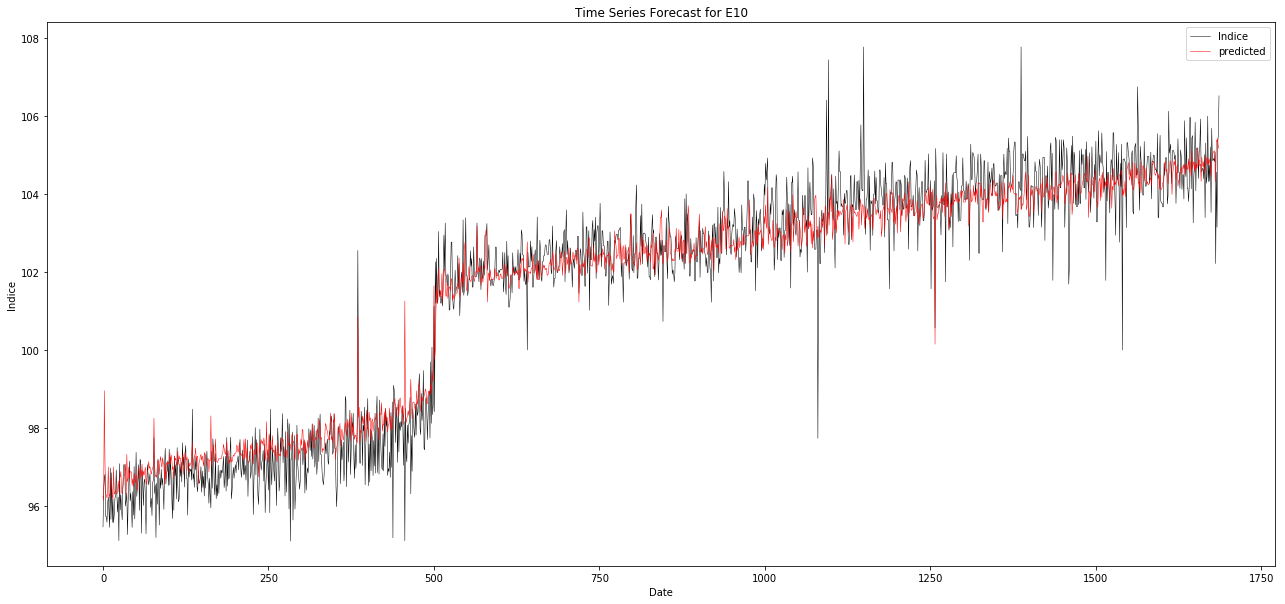

In [201]:
plt.figure(figsize=(22,10))

pr = trainingSummary.predictions.toPandas()

plt.plot(pr['indice_base100'],label = "Indice", linewidth=0.5, color = "black") # replace m by price
plt.plot(pr['prediction'],label = "predicted", linewidth=0.5, color = "red") # replace by the prediction values
plt.title("Time Series Forecast for E10")
plt.xlabel("Date")
plt.ylabel("Indice")
plt.legend()

plt.show()

## E85

In [104]:
table_features_E85 = spark.sql('SELECT * '
          'FROM table '
          'WHERE libelle_carburant = "E85" '
          'ORDER BY unique_ID, date, libelle_carburant'
).cache()

In [105]:
from pyspark.sql.functions import monotonically_increasing_id, lag
from pyspark.sql.window import Window
# Add ID to be used by the window function
table_features_E85 = table_features_E85.withColumn('id', monotonically_increasing_id())
# Set the window
w = Window.orderBy("id")
# Create the lagged value -1
value_lag = lag('indice_base100').over(w)
# Add the lagged values to a new column
table_features_E85 = table_features_E85.withColumn('indice_base100_lag_1', value_lag)

# Create the lagged value -2
value_lag = lag('indice_base100_lag_1').over(w)
# Add the lagged values to a new column
table_features_E85 = table_features_E85.withColumn('indice_base100_lag_2', value_lag)

# Create the lagged value -3
value_lag = lag('indice_base100_lag_2').over(w)
# Add the lagged values to a new column
table_features_E85 = table_features_E85.withColumn('indice_base100_lag_3', value_lag)

# Create the lagged value -4
value_lag = lag('indice_base100_lag_3').over(w)
# Add the lagged values to a new column
table_features_E85 = table_features_E85.withColumn('indice_base100_lag_4', value_lag)

# Create the lagged value -5
value_lag = lag('indice_base100_lag_4').over(w)
# Add the lagged values to a new column
table_features_E85 = table_features_E85.withColumn('indice_base100_lag_5', value_lag)

# Create the lagged value -6
value_lag = lag('indice_base100_lag_5').over(w)
# Add the lagged values to a new column
table_features_E85 = table_features_E85.withColumn('indice_base100_lag_6', value_lag)


In [106]:
sqlsc.registerDataFrameAsTable(table_features_E85, 'table_features_E85')

In [107]:
table_features_new_E85 = spark.sql(
    'SELECT * FROM table_features_E85 '
    'WHERE indice_base100_lag_6 IS NOT NULL '
).cache()

In [108]:
sqlsc.registerDataFrameAsTable(table_features_new_E85, 'table_features_new_E85')

In [109]:
table_E85 = sqlsc.sql('SELECT date, libelle_carburant, indice_base100, indice_base100_lag_1, indice_base100_lag_2, indice_base100_lag_3, indice_base100_lag_4, indice_base100_lag_5, indice_base100_lag_6 from table_features_new_E85').toPandas()

In [110]:
table_E85

Empty DataFrame
Columns: [date, libelle_carburant, indice_base100, indice_base100_lag_1, indice_base100_lag_2, indice_base100_lag_3, indice_base100_lag_4, indice_base100_lag_5, indice_base100_lag_6]
Index: []

In [111]:
from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StandardScaler
from pyspark.ml import Pipeline
from pyspark.sql.functions import *

vectorAssembler = VectorAssembler(inputCols = ["indice_base100_lag_1", "indice_base100_lag_2", "indice_base100_lag_3", "indice_base100_lag_4", "indice_base100_lag_5", "indice_base100_lag_6"], outputCol = 'features')
table_features_E85 = vectorAssembler.transform(table_features_new_E85)
table_features_E85 = table_features_E85.select(['features', 'indice_base100'])
table_features_E85.show(3)

+--------+--------------+
|features|indice_base100|
+--------+--------------+
+--------+--------------+



In [146]:
splits = table_features_E85.randomSplit([0.7, 0.3])
train_E85 = splits[0]
test_E85 = splits[1]

In [ ]:
lr = LinearRegression(featuresCol = 'features', labelCol='indice_base100', maxIter=10, regParam=0.3, elasticNetParam=0.8)
lr_model = lr.fit(train_E85)
print("Coefficients: " + str(lr_model.coefficients))
print("Intercept: " + str(lr_model.intercept))

In [ ]:
trainingSummary = lr_model.summary
print("RMSE: %f" % trainingSummary.rootMeanSquaredError)
print("r2: %f" % trainingSummary.r2)

In [ ]:
lr_predictions = lr_model.transform(train_E85)
lr_predictions.select("prediction","indice_base100","features").show(5)
from pyspark.ml.evaluation import RegressionEvaluator
lr_evaluator = RegressionEvaluator(predictionCol="prediction", \
                 labelCol="indice_base100",metricName="r2")
print("R Squared (R2) on test data = %g" % lr_evaluator.evaluate(lr_predictions))

In [ ]:
predictions = lr_model.transform(test_E85)
predictions.select("prediction","indice_base100","features").show()

# Problème:
Table vide peut-être car il n'y a pas de E85 pour le code postal 1000

## GPLc

In [202]:
table_features_GPLc = spark.sql('SELECT * '
          'FROM table '
          'WHERE libelle_carburant = "GPLc" '
          'ORDER BY unique_ID, date, libelle_carburant'
).cache()

In [203]:
from pyspark.sql.functions import monotonically_increasing_id, lag
from pyspark.sql.window import Window
# Add ID to be used by the window function
table_features_GPLc = table_features_GPLc.withColumn('id', monotonically_increasing_id())
# Set the window
w = Window.orderBy("id")
# Create the lagged value -1
value_lag = lag('indice_base100').over(w)
# Add the lagged values to a new column
table_features_GPLc = table_features_GPLc.withColumn('indice_base100_lag_1', value_lag)

# Create the lagged value -2
value_lag = lag('indice_base100_lag_1').over(w)
# Add the lagged values to a new column
table_features_GPLc = table_features_GPLc.withColumn('indice_base100_lag_2', value_lag)

# Create the lagged value -3
value_lag = lag('indice_base100_lag_2').over(w)
# Add the lagged values to a new column
table_features_GPLc = table_features_GPLc.withColumn('indice_base100_lag_3', value_lag)

# Create the lagged value -4
value_lag = lag('indice_base100_lag_3').over(w)
# Add the lagged values to a new column
table_features_GPLc = table_features_GPLc.withColumn('indice_base100_lag_4', value_lag)

# Create the lagged value -5
value_lag = lag('indice_base100_lag_4').over(w)
# Add the lagged values to a new column
table_features_GPLc = table_features_GPLc.withColumn('indice_base100_lag_5', value_lag)

# Create the lagged value -6
value_lag = lag('indice_base100_lag_5').over(w)
# Add the lagged values to a new column
table_features_GPLc = table_features_GPLc.withColumn('indice_base100_lag_6', value_lag)

In [204]:
sqlsc.registerDataFrameAsTable(table_features_GPLc, 'table_features_GPLc')

In [205]:
table_features_new_GPLc = spark.sql(
    'SELECT * FROM table_features_GPLc '
    'WHERE indice_base100_lag_6 IS NOT NULL '
).cache()

In [206]:
sqlsc.registerDataFrameAsTable(table_features_new_GPLc, 'table_features_new_GPLc')

In [207]:
table_GPLc = sqlsc.sql('SELECT date, libelle_carburant, indice_base100, indice_base100_lag_1, indice_base100_lag_2, indice_base100_lag_3, indice_base100_lag_4, indice_base100_lag_5, indice_base100_lag_6 from table_features_new_GPLc').toPandas()

In [208]:
table_GPLc

date libelle_carburant  indice_base100  indice_base100_lag_1  \
0   2017-04-28              GPLc       93.164557             93.417722   
1   2017-06-13              GPLc       96.493506             93.164557   
2   2017-06-19              GPLc       96.233766             96.493506   
3   2017-09-14              GPLc       96.103896             96.233766   
4   2017-10-03              GPLc       94.810127             96.103896   
5   2017-10-19              GPLc       95.189873             94.810127   
6   2016-04-07              GPLc       90.259740             95.189873   
7   2017-01-18              GPLc       91.948052             90.259740   
8   2017-01-28              GPLc       92.727273             91.948052   
9   2017-03-01              GPLc       95.714286             92.727273   
10  2017-03-06              GPLc       93.164557             95.714286   
11  2017-04-05              GPLc       93.417722             93.164557   
12  2017-04-28              GPLc       93.164557             93.417722   
13  2017-06-13              GPLc       96.493506             93.164557   
14  2017-06-19              GPLc       96.233766             96.493506   
15  2017-09-14              GPLc       96.103896             96.233766   
16  2017-10-03              GPLc       94.810127             96.103896   
17  2017-10-19              GPLc       95.189873             94.810127   

    indice_base100_lag_2  indice_base100_lag_3  indice_base100_lag_4  \
0              93.164557             95.714286             92.727273   
1              93.417722             93.164557             95.714286   
2              93.164557             93.417722             93.164557   
3              96.493506             93.164557             93.417722   
4              96.233766             96.493506             93.164557   
5              96.103896             96.233766             96.493506   
6              94.810127             96.103896             96.233766   
7              95.189873             94.810127             96.103896   
8              90.259740             95.189873             94.810127   
9              91.948052             90.259740             95.189873   
10             92.727273             91.948052             90.259740   
11             95.714286             92.727273             91.948052   
12             93.164557             95.714286             92.727273   
13             93.417722             93.164557             95.714286   
14             93.164557             93.417722             93.164557   
15             96.493506             93.164557             93.417722   
16             96.233766             96.493506             93.164557   
17             96.103896             96.233766             96.493506   

    indice_base100_lag_5  indice_base100_lag_6  
0              91.948052             90.259740  
1              92.727273             91.948052  
2              95.714286             92.727273  
3              93.164557             95.714286  
4              93.417722             93.164557  
5              93.164557             93.417722  
6              96.493506             93.164557  
7              96.233766             96.493506  
8              96.103896             96.233766  
9              94.810127             96.103896  
10             95.189873             94.810127  
11             90.259740             95.189873  
12             91.948052             90.259740  
13             92.727273             91.948052  
14             95.714286             92.727273  
15             93.164557             95.714286  
16             93.417722             93.164557  
17             93.164557             93.417722

In [209]:
from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StandardScaler
from pyspark.ml import Pipeline
from pyspark.sql.functions import *

vectorAssembler = VectorAssembler(inputCols = ["indice_base100_lag_1", "indice_base100_lag_2", "indice_base100_lag_3", "indice_base100_lag_4", "indice_base100_lag_5", "indice_base100_lag_6"], outputCol = 'features')
table_features_GPLc = vectorAssembler.transform(table_features_new_GPLc)
table_features_GPLc = table_features_GPLc.select(['features', 'indice_base100'])
table_features_GPLc.show(3)

+--------------------+-----------------+
|            features|   indice_base100|
+--------------------+-----------------+
|[93.4177215189873...|93.16455696202532|
|[93.1645569620253...|96.49350649350649|
|[96.4935064935064...|96.23376623376623|
+--------------------+-----------------+
only showing top 3 rows



In [210]:
splits = table_features_GPLc.randomSplit([0.7, 0.3])
train_GPLc = splits[0]
test_GPLc = splits[1]

In [211]:
lr = LinearRegression(featuresCol = 'features', labelCol='indice_base100', maxIter=10, regParam=0.3, elasticNetParam=0.8)
lr_model = lr.fit(train_GPLc)
print("Coefficients: " + str(lr_model.coefficients))
print("Intercept: " + str(lr_model.intercept))

Coefficients: [0.4132077710426623,0.0,-0.22158265658976903,0.3116780307613767,-0.03887668996057859,-0.16242422123978206]
Intercept: 66.22028261952595


In [212]:
trainingSummary = lr_model.summary
print("RMSE: %f" % trainingSummary.rootMeanSquaredError)
print("r2: %f" % trainingSummary.r2)

RMSE: 0.831774
r2: 0.718327


In [213]:
lr_predictions = lr_model.transform(train_GPLc)
lr_predictions.select("prediction","indice_base100","features").show(5)
from pyspark.ml.evaluation import RegressionEvaluator
lr_evaluator = RegressionEvaluator(predictionCol="prediction", \
                 labelCol="indice_base100",metricName="r2")
print("R Squared (R2) on test data = %g" % lr_evaluator.evaluate(lr_predictions))

+-----------------+-----------------+--------------------+
|       prediction|   indice_base100|            features|
+-----------------+-----------------+--------------------+
|93.04736913307504|91.94805194805194|[90.2597402597402...|
|93.30484482342871|92.72727272727272|[91.9480519480519...|
|95.36547143260192|96.49350649350649|[93.1645569620253...|
|95.36547143260192|96.49350649350649|[93.1645569620253...|
| 94.2786352345598|93.16455696202532|[93.4177215189873...|
+-----------------+-----------------+--------------------+
only showing top 5 rows

R Squared (R2) on test data = 0.718327


In [214]:
predictions = lr_model.transform(test_GPLc)
predictions.select("prediction","indice_base100","features").show()

+-----------------+-----------------+--------------------+
|       prediction|   indice_base100|            features|
+-----------------+-----------------+--------------------+
|94.90900718438503|95.71428571428571|[92.7272727272727...|
|93.85789287847493|93.41772151898734|[93.1645569620253...|
| 94.2786352345598|93.16455696202532|[93.4177215189873...|
|95.35250594225772|95.18987341772151|[94.8101265822784...|
| 95.3689434385949|90.25974025974025|[95.1898734177215...|
|95.28917619862716| 96.1038961038961|[96.2337662337662...|
+-----------------+-----------------+--------------------+



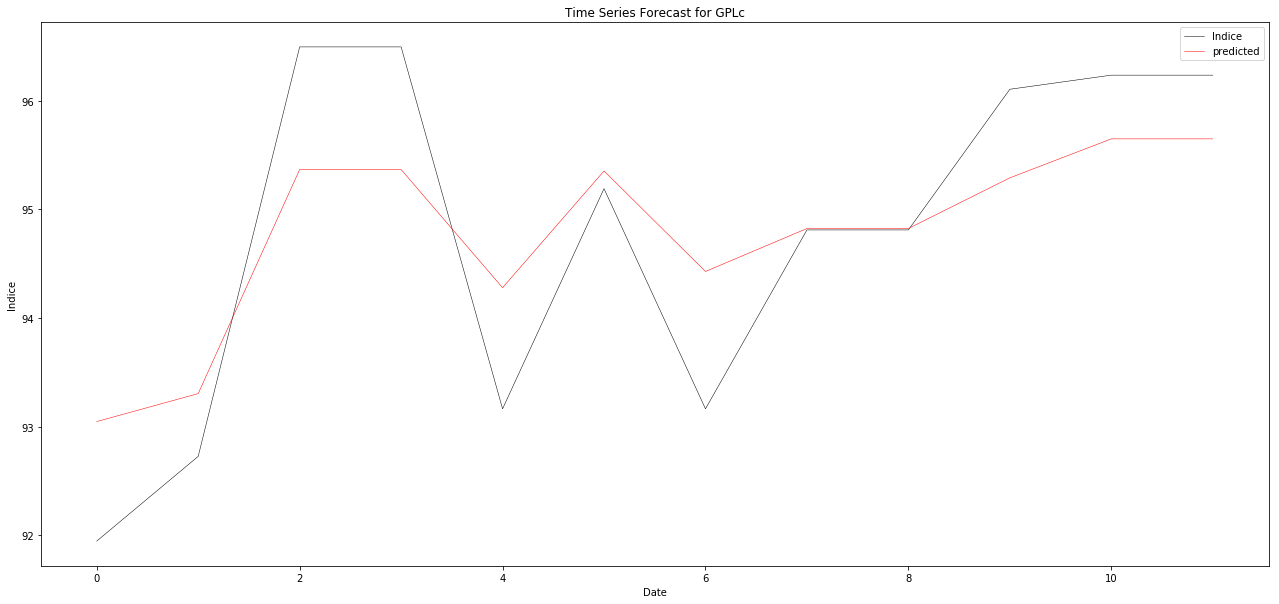

In [215]:
plt.figure(figsize=(22,10))

pr = trainingSummary.predictions.toPandas()

plt.plot(pr['indice_base100'],label = "Indice", linewidth=0.5, color = "black") # replace m by price
plt.plot(pr['prediction'],label = "predicted", linewidth=0.5, color = "red") # replace by the prediction values
plt.title("Time Series Forecast for GPLc")
plt.xlabel("Date")
plt.ylabel("Indice")
plt.legend()

plt.show()

## SP98

In [216]:
table_features_SP98 = spark.sql('SELECT * '
          'FROM table '
          'WHERE libelle_carburant = "SP98" '
          'ORDER BY unique_ID, date, libelle_carburant'
).cache()

In [217]:
from pyspark.sql.functions import monotonically_increasing_id, lag
from pyspark.sql.window import Window
# Add ID to be used by the window function
table_features_SP98 = table_features_SP98.withColumn('id', monotonically_increasing_id())
# Set the window
w = Window.orderBy("id")
# Create the lagged value -1
value_lag = lag('indice_base100').over(w)
# Add the lagged values to a new column
table_features_SP98 = table_features_SP98.withColumn('indice_base100_lag_1', value_lag)

# Create the lagged value -2
value_lag = lag('indice_base100_lag_1').over(w)
# Add the lagged values to a new column
table_features_SP98 = table_features_SP98.withColumn('indice_base100_lag_2', value_lag)

# Create the lagged value -3
value_lag = lag('indice_base100_lag_2').over(w)
# Add the lagged values to a new column
table_features_SP98 = table_features_SP98.withColumn('indice_base100_lag_3', value_lag)

# Create the lagged value -4
value_lag = lag('indice_base100_lag_3').over(w)
# Add the lagged values to a new column
table_features_SP98 = table_features_SP98.withColumn('indice_base100_lag_4', value_lag)

# Create the lagged value -5
value_lag = lag('indice_base100_lag_4').over(w)
# Add the lagged values to a new column
table_features_SP98 = table_features_SP98.withColumn('indice_base100_lag_5', value_lag)

# Create the lagged value -6
value_lag = lag('indice_base100_lag_5').over(w)
# Add the lagged values to a new column
table_features_SP98 = table_features_SP98.withColumn('indice_base100_lag_6', value_lag)

In [218]:
sqlsc.registerDataFrameAsTable(table_features_SP98, 'table_features_SP98')

In [219]:
table_features_new_SP98 = spark.sql(
    'SELECT * FROM table_features_SP98 '
    'WHERE indice_base100_lag_6 IS NOT NULL '
).cache()

In [220]:
sqlsc.registerDataFrameAsTable(table_features_new_SP98, 'table_features_new_SP98')

In [221]:
table_98 = sqlsc.sql('SELECT date, libelle_carburant, indice_base100, indice_base100_lag_1, indice_base100_lag_2, indice_base100_lag_3, indice_base100_lag_4, indice_base100_lag_5, indice_base100_lag_6 from table_features_new_SP98').toPandas()

In [222]:
table_98

date libelle_carburant  indice_base100  indice_base100_lag_1  \
0     2016-01-11              SP98      102.240790            102.205323   
1     2016-01-12              SP98      101.441578            102.240790   
2     2016-01-14              SP98      102.463433            101.441578   
3     2016-01-15              SP98      102.078522            102.463433   
4     2016-01-16              SP98      101.924557            102.078522   
5     2016-01-18              SP98      102.792863            101.924557   
6     2016-01-20              SP98      103.127443            102.792863   
7     2016-01-21              SP98      103.049257            103.127443   
8     2016-01-22              SP98      102.501955            103.049257   
9     2016-01-24              SP98      103.909304            102.501955   
10    2016-01-25              SP98      102.892885            103.909304   
11    2016-01-28              SP98      103.049257            102.892885   
12    2016-01-29              SP98      103.205629            103.049257   
13    2016-01-30              SP98      103.362002            103.205629   
14    2016-02-03              SP98      102.872671            103.362002   
15    2016-02-04              SP98      102.482545            102.872671   
16    2016-02-05              SP98      102.094647            102.482545   
17    2016-02-06              SP98      102.094647            102.094647   
18    2016-02-07              SP98      103.025601            102.094647   
19    2016-02-08              SP98      103.971406            103.025601   
20    2016-02-09              SP98      104.368546            103.971406   
21    2016-02-10              SP98      104.130262            104.368546   
22    2016-02-12              SP98      102.938840            104.130262   
23    2016-02-13              SP98      102.779984            102.938840   
24    2016-02-15              SP98      104.196933            102.779984   
25    2016-02-17              SP98      103.935743            104.196933   
26    2016-02-18              SP98      103.614458            103.935743   
27    2016-02-19              SP98      103.373494            103.614458   
28    2016-02-22              SP98      103.694779            103.373494   
29    2016-02-25              SP98      103.212851            103.694779   
...          ...               ...             ...                   ...   
3232  2017-12-02              SP98      103.363700            103.368421   
3233  2017-12-03              SP98      104.695165            103.363700   
3234  2017-12-04              SP98      103.223546            104.695165   
3235  2017-12-05              SP98      103.223546            103.223546   
3236  2017-12-06              SP98      103.293623            103.223546   
3237  2017-12-07              SP98      103.433777            103.293623   
3238  2017-12-08              SP98      102.733006            103.433777   
3239  2017-12-09              SP98      102.873160            102.733006   
3240  2017-12-10              SP98      104.344779            102.873160   
3241  2017-12-11              SP98      102.873160            104.344779   
3242  2017-12-12              SP98      103.083392            102.873160   
3243  2017-12-13              SP98      103.083392            103.083392   
3244  2017-12-14              SP98      103.013315            103.083392   
3245  2017-12-15              SP98      102.803083            103.013315   
3246  2017-12-16              SP98      103.083392            102.803083   
3247  2017-12-17              SP98      104.064471            103.083392   
3248  2017-12-18              SP98      103.153469            104.064471   
3249  2017-12-19              SP98      103.079076            103.153469   
3250  2017-12-20              SP98      103.149055            103.079076   
3251  2017-12-21              SP98      103.289013            103.149055   
3252  2017-12-22              SP98      102.239328          

In [223]:
from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StandardScaler
from pyspark.ml import Pipeline
from pyspark.sql.functions import *

vectorAssembler = VectorAssembler(inputCols = ["indice_base100_lag_1", "indice_base100_lag_2", "indice_base100_lag_3", "indice_base100_lag_4", "indice_base100_lag_5", "indice_base100_lag_6"], outputCol = 'features')
table_features_SP98 = vectorAssembler.transform(table_features_new_SP98)
table_features_SP98 = table_features_SP98.select(['features', 'indice_base100'])
table_features_SP98.show(3)

+--------------------+------------------+
|            features|    indice_base100|
+--------------------+------------------+
|[102.205323193916...|102.24078997341437|
|[102.240789973414...|101.44157814871015|
|[101.441578148710...|102.46343341031563|
+--------------------+------------------+
only showing top 3 rows



In [224]:
splits = table_features_SP98.randomSplit([0.7, 0.3])
train_SP98 = splits[0]
test_SP98 = splits[1]

In [225]:
lr = LinearRegression(featuresCol = 'features', labelCol='indice_base100', maxIter=10, regParam=0.3, elasticNetParam=0.8)
lr_model = lr.fit(train_SP98)
print("Coefficients: " + str(lr_model.coefficients))
print("Intercept: " + str(lr_model.intercept))

Coefficients: [0.25296731671683687,0.1962074313564307,0.16878824593788752,0.11493547746760614,0.10081900911381717,0.06136919840957231]
Intercept: 10.680672456459039


In [226]:
trainingSummary = lr_model.summary
print("RMSE: %f" % trainingSummary.rootMeanSquaredError)
print("r2: %f" % trainingSummary.r2)

RMSE: 1.342503
r2: 0.843711


In [227]:
lr_predictions = lr_model.transform(train_SP98)
lr_predictions.select("prediction","indice_base100","features").show(5)
from pyspark.ml.evaluation import RegressionEvaluator
lr_evaluator = RegressionEvaluator(predictionCol="prediction", \
                 labelCol="indice_base100",metricName="r2")
print("R Squared (R2) on test data = %g" % lr_evaluator.evaluate(lr_predictions))

+-----------------+-----------------+--------------------+
|       prediction|   indice_base100|            features|
+-----------------+-----------------+--------------------+
|94.99602693619997|94.46808510638299|[93.1914893617021...|
|95.81769103321261|94.53333333333333|[93.8255033557047...|
|95.05144442652984|94.46808510638299|[93.8297872340425...|
|95.12283419504826|95.86666666666666|[94.0,92.60000000...|
|95.18212070970354|95.25179856115109|[94.0425531914893...|
+-----------------+-----------------+--------------------+
only showing top 5 rows

R Squared (R2) on test data = 0.843711


In [228]:
predictions = lr_model.transform(test_SP98)
predictions.select("prediction","indice_base100","features").show()

+-----------------+-----------------+--------------------+
|       prediction|   indice_base100|            features|
+-----------------+-----------------+--------------------+
|95.36159058299722|             94.0|[92.6000000000000...|
|96.05709962220442|94.74025974025975|[93.9610389610389...|
|99.62046891893576|96.24113475177305|[94.1843971631205...|
|95.57475757504295|94.58904109589041|[94.3150684931506...|
|95.55014921261946|94.64788732394366|[94.3661971830985...|
|95.31764494074342|94.04255319148938|[94.3971631205673...|
|95.11968305477852|94.68085106382979|[94.4680851063829...|
| 96.0723300054085|96.35761589403974|[94.5033112582781...|
|95.45671474834424| 95.6934306569343|[94.5323741007194...|
|95.43499472430324|95.61151079136691|[94.5323741007194...|
|95.61762419504711|96.33333333333334|[94.5333333333333...|
|95.50308066201583|94.65753424657534|[94.5890410958904...|
|95.43314223507026|95.21126760563381|[94.6478873239436...|
|95.65261028048172|95.53956834532376|[94.6762589928057..

In [229]:
sqlsc.registerDataFrameAsTable(predictions, 'predictions_SP98')

In [230]:
pred_SP98 = sqlsc.sql('SELECT indice_base100, prediction FROM predictions_SP98').toPandas()

In [231]:
pred_SP98

indice_base100  prediction
0         94.000000   95.361591
1         94.740260   96.057100
2         96.241135   99.620469
3         94.589041   95.574758
4         94.647887   95.550149
5         94.042553   95.317645
6         94.680851   95.119683
7         96.357616   96.072330
8         95.693431   95.456715
9         95.611511   95.434995
10        96.333333   95.617624
11        94.657534   95.503081
12        95.211268   95.433142
13        95.539568   95.652610
14        94.893617   95.194615
15        95.066667   95.438698
16        95.782313   95.601813
17        96.013072   96.036782
18        96.500000   96.064243
19        95.000000   96.075066
20        94.820144   95.837257
21        93.829787   95.219772
22        95.642857   96.049015
23        96.282051   95.905856
24        95.337838   96.298954
25        95.281690   96.231988
26        94.933333   95.501368
27        96.666667   96.175226
28        94.577465   95.882330
29        95.310345   96.041343
..              ...         ...
934      106.060606  105.341061
935      103.958178  104.248166
936      102.047005  105.288305
937      105.307051  104.766368
938      103.867792  104.550976
939      103.826343  104.570945
940      105.377147  104.519895
941      104.331591  104.231101
942      104.691165  104.895107
943      105.749806  104.606735
944      103.535354  104.291311
945      106.915307  104.338454
946      106.526807  104.771168
947      104.299481  104.231470
948      106.245353  103.405224
949      103.192279  104.540107
950      103.964099  104.777127
951      105.361305  105.426584
952      105.430566  104.697560
953      105.837756  105.413135
954      105.989386  105.170793
955      104.809052  104.878153
956      105.869873  104.773933
957      106.171004  106.346337
958      104.895105  105.519464
959      106.060606  105.300874
960      103.588144  105.498476
961      100.988593  104.001870
962      104.455807  104.269950
963      101.656315  103.948908

[964 rows x 2 columns]

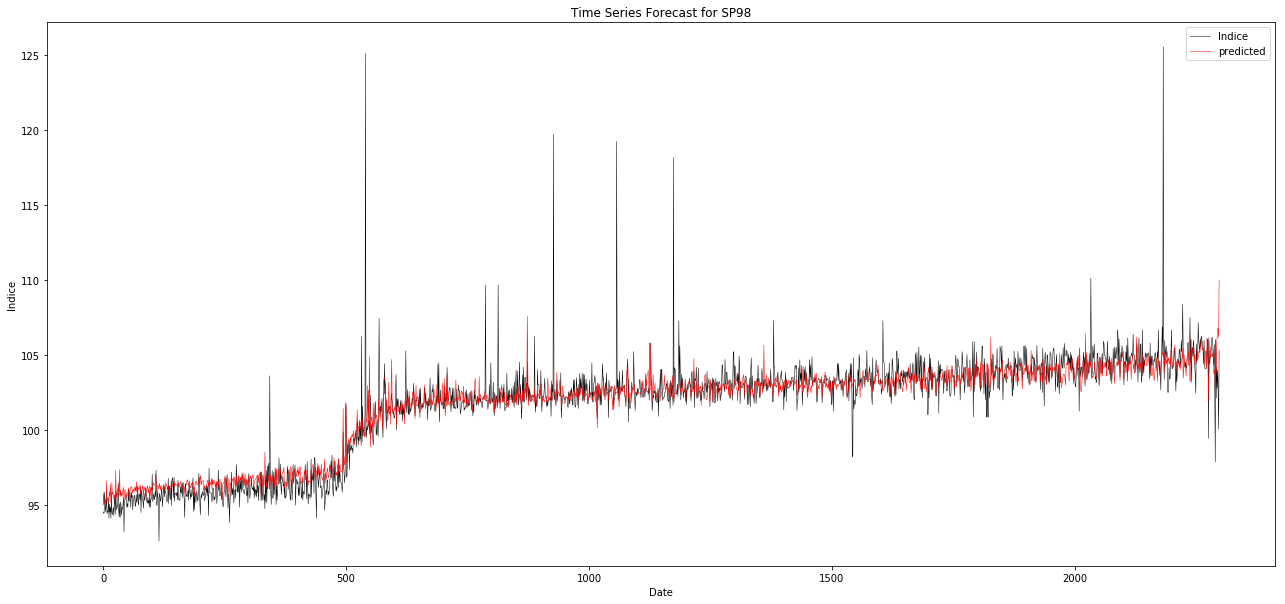

In [232]:
plt.figure(figsize=(22,10))

pr = trainingSummary.predictions.toPandas()
#m = pr['indice_base100']
#p = pr['predictions']


plt.plot(pr['indice_base100'],label = "Indice", linewidth=0.5, color = "black") # replace m by price
plt.plot(pr['prediction'],label = "predicted", linewidth=0.5, color = "red") # replace by the prediction values
plt.title("Time Series Forecast for SP98")
plt.xlabel("Date")
plt.ylabel("Indice")
plt.legend()

plt.show()

# Résultats
On peut voir que lorsque nous faisions la prédiction sur "prix_day" nous avions toujours la même valeur de prédiction, c'est pouquoi nous avons décider de faire la prédiction sur "indice_base100". 

Aussi, de manière générale, on peut résumé nos résultats de R2 dans la table suivante

| Carburants |   R2   |
|------------|--------|
|    SP95    |0.747517|
|    SP98    |0.863352|
|     E10    |0.944197|
|     E85    |  vide  |
|    GPLc    |0.766848|
|   Gazole   |0.915394|